In [ ]:
# !pip install tensorflow rdkit-pypi gym

# Ethane

imports

In [ ]:
import gym
from gym import spaces
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from rdkit.Chem.QED import qed
import tensorflow as tf
from tensorflow.keras import layers

Environment

In [ ]:
class MoleculeEnv(gym.Env):
    def __init__(self):
        super(MoleculeEnv, self).__init__()
        self.action_space = spaces.Discrete(4)  # Define 4 actions for simplicity
        self.observation_space = spaces.Box(low=0, high=1, shape=(100,), dtype=np.float32)
        self.current_molecule = None
        self.reset()

    def reset(self):
        self.current_molecule = Chem.MolFromSmiles('CC')  # Start with a simple ethane molecule
        return self._get_observation()

    def step(self, action):
        self._take_action(action)
        reward = self._compute_reward()
        done = self._is_done()
        obs = self._get_observation()
        return obs, reward, done, {}

    def _take_action(self, action):
        # Modify the molecule based on the action
        if action == 0:
            self.current_molecule = Chem.AddHs(self.current_molecule)  # Add hydrogen atoms
        elif action == 1:
            self.current_molecule = Chem.RemoveHs(self.current_molecule)  # Remove hydrogen atoms
        elif action == 2:
            self.current_molecule = self._modify_molecule(self._add_carbon_chain)  # Add a carbon chain
        elif action == 3:
            self.current_molecule = self._modify_molecule(self._remove_carbon_chain)  # Remove a carbon chain

    def _modify_molecule(self, modification_func):
        # Apply the modification and ensure it's valid
        mol = modification_func(self.current_molecule)
        if mol is not None:
            return mol
        return self.current_molecule

    def _add_carbon_chain(self, mol):
        # Add a carbon chain to the molecule
        try:
            mol = Chem.RWMol(mol)
            ethane = Chem.MolFromSmiles('CC')
            mol = Chem.CombineMols(mol, ethane)
            smi = AllChem.MolToSmiles(mol)
            return Chem.MolFromSmiles(smi)
        except ValueError:
            return None


    def _remove_carbon_chain(self, mol):
        # Remove a carbon chain from the molecule
        try:
            smi = Chem.MolToSmiles(mol)
            if 'CC' in smi:
                smi = smi.replace('CC', '', 1)
                return Chem.MolFromSmiles(smi)
            return None
        except ValueError:
            return None

    def _get_observation(self):
        return np.array(AllChem.GetMorganFingerprintAsBitVect(self.current_molecule, 2, nBits=100), dtype=np.float32)

    def _compute_reward(self):
        # Reward based on QED score (placeholder for binding affinity with JAK2)
        try:
            return qed(self.current_molecule)
        except:
            return 0.0

    def _is_done(self):
        # Done if the molecule has more than 50 heavy atoms
        return self.current_molecule.GetNumHeavyAtoms() > 50

Agent

In [ ]:
class ActorCritic(tf.keras.Model):
    def __init__(self, action_space):
        super(ActorCritic, self).__init__()
        self.dense1 = layers.Dense(128, activation='relu')
        self.dense2 = layers.Dense(128, activation='relu')
        self.actor = layers.Dense(action_space, activation='softmax')
        self.critic = layers.Dense(1, activation='linear')

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        return self.actor(x), self.critic(x)

In [ ]:
env = MoleculeEnv()
model = ActorCritic(action_space=env.action_space.n)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
def compute_loss(action_probs, values, rewards):
    advantage = rewards - values
    actor_loss = -tf.math.log(action_probs) * advantage
    critic_loss = tf.square(advantage)
    return tf.reduce_mean(actor_loss + critic_loss)

@tf.function
def train_step(state, action, reward, next_state, done):
    state = tf.convert_to_tensor([state], dtype=tf.float32)
    next_state = tf.convert_to_tensor([next_state], dtype=tf.float32)
    action = tf.convert_to_tensor([action], dtype=tf.int32)
    reward = tf.convert_to_tensor([reward], dtype=tf.float32)
    done = tf.convert_to_tensor([done], dtype=tf.float32)

    with tf.GradientTape() as tape:
        action_probs, value = model(state)
        _, next_value = model(next_state)

        action_prob = tf.reduce_sum(action_probs * tf.one_hot(action, env.action_space.n), axis=1)
        td_target = reward + (1 - done) * next_value
        td_error = td_target - value
        loss = compute_loss(action_prob, value, reward)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [ ]:
num_episodes = 500
for episode in range(num_episodes):
    state = env.reset()
    done = False
    episode_reward = 0

    while not done:
        state = np.expand_dims(state, axis=0)
        action_probs, _ = model(state)
        action = np.random.choice(len(action_probs[0]), p=action_probs[0].numpy())
        next_state, reward, done, _ = env.step(action)
        train_step(state[0], action, reward, next_state, done)
        state = next_state
        episode_reward += reward

    print(f'Episode {episode + 1}/{num_episodes}, Total Reward: {episode_reward}')

print("Training finished!")

[15:40:17] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:40:17] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:40:18] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:40:18] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:40:19] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:40:19] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:40:20] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.C

Episode 1/500, Total Reward: 28.307310271963463


[15:40:21] SMILES Parse Error: syntax error while parsing: .CC
[15:40:21] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:40:22] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:40:22] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:40:22] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:40:22] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:40:23] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:40:23] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:40:23] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:40:23] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:40:23] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:40:23] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC

Episode 2/500, Total Reward: 29.84274434550545


[15:40:28] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:40:28] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:40:28] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:40:28] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:40:28] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:40:28] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:40:29] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:40:29] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:40:30] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:40:30] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:40:31] SMILES Parse Er

Episode 3/500, Total Reward: 36.00968089388465


[15:40:32] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:40:32] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:40:33] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:40:33] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:40:33] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:40:33] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:40:33] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:40:33] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:40:33] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.

Episode 4/500, Total Reward: 41.42474887764896


[15:40:34] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:40:34] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:40:34] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:40:34] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:40:34] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:40:34] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:40:35] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:40:35] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:40:35] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:40:35] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:40:35] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:40:35] SMILES Parse Error: Failed 

Episode 5/500, Total Reward: 49.80540735326449


[15:40:36] SMILES Parse Error: syntax error while parsing: .CC
[15:40:36] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:40:36] SMILES Parse Error: syntax error while parsing: .CC
[15:40:36] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:40:36] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:40:36] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:40:36] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:40:36] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:40:36] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:40:36] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:40:36] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:40:36] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:40:37] SMILES Parse Error: syntax error while

Episode 6/500, Total Reward: 51.927538903401164


[15:40:39] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:40:39] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:40:39] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:40:39] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:40:39] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:40:39] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:40:39] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:40:39] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:40:39] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:40:39] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:40:40] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:40:40] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.C

Episode 7/500, Total Reward: 78.60014713535625


[15:40:41] SMILES Parse Error: syntax error while parsing: .CC
[15:40:41] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:40:41] SMILES Parse Error: syntax error while parsing: .CC
[15:40:41] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:40:41] SMILES Parse Error: syntax error while parsing: .CC
[15:40:41] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:40:41] SMILES Parse Error: syntax error while parsing: .CC
[15:40:41] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:40:41] SMILES Parse Error: syntax error while parsing: .CC
[15:40:41] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:40:41] SMILES Parse Error: syntax error while parsing: .CC
[15:40:41] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:40:41] SMILES Parse Error: syntax error while parsing: .CC
[15:40:41] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:40:41] SMILES Parse Err

Episode 8/500, Total Reward: 58.324148878979145


[15:40:43] SMILES Parse Error: syntax error while parsing: .CC
[15:40:43] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:40:43] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:40:43] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:40:43] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:40:43] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:40:43] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:40:43] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:40:43] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:40:43] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:40:43] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:40:43] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for in

Episode 9/500, Total Reward: 68.8470171169174


[15:40:45] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:40:45] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:40:45] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:40:45] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:40:45] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:40:45] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:40:45] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:40:45] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' fo

Episode 10/500, Total Reward: 27.635220105239352


[15:40:45] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:40:45] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:40:45] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:40:45] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:40:45] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:40:45] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:40:45] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:40:45] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:40:45] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:40:45] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:40:45] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:40:45] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.C

Episode 11/500, Total Reward: 53.37609149956436


[15:40:46] SMILES Parse Error: syntax error while parsing: .CC
[15:40:46] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:40:46] SMILES Parse Error: syntax error while parsing: .CC
[15:40:46] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:40:46] SMILES Parse Error: syntax error while parsing: .CC
[15:40:46] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:40:46] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:40:46] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:40:46] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:40:46] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:40:46] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:40:46] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:40:46] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:40:46] SMILES Parse Erro

Episode 12/500, Total Reward: 65.95436745979504


[15:40:48] SMILES Parse Error: syntax error while parsing: .CC
[15:40:48] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:40:48] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:40:48] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:40:48] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:40:48] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:40:48] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:40:48] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:40:48] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:40:48] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:40:48] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:40:48] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:40:48] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:40:48] SM

Episode 13/500, Total Reward: 80.19590397747453


[15:40:50] SMILES Parse Error: syntax error while parsing: .CC
[15:40:50] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:40:50] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:40:50] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:40:50] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:40:50] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:40:50] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:40:50] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:40:50] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:40:50] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:40:50] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:40:50] SMILES Parse Error: Failed parsing SMILES '.C

Episode 14/500, Total Reward: 108.85431211310744


[15:40:52] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:40:52] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:40:52] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:40:52] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:40:52] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:40:52] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:40:52] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:40:52] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:40:52] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:40:52] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:40:52] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:40:52] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:40:53] SMILES Parse Error: 

Episode 15/500, Total Reward: 50.854334231741134


[15:40:54] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:40:54] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:40:54] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:40:54] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:40:54] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:40:54] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:40:54] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:40:54] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:40:54] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:40:54] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:40:55] SMILES Parse Error: syntax error while par

Episode 16/500, Total Reward: 40.99653351338332


[15:40:55] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:40:55] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:40:55] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:40:55] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:40:56] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:40:56] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:40:56] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:40:56] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:40:56] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.

Episode 17/500, Total Reward: 53.71991259836962


[15:40:56] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:40:56] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:40:57] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:40:57] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:40:57] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:40:57] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:40:57] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:40:57] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Episode 18/500, Total Reward: 75.7341672009028


[15:40:58] SMILES Parse Error: syntax error while parsing: .CC
[15:40:58] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:40:59] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:40:59] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:41:00] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:41:00] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:41:00] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:41:00] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:41:01] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:41:01] SMILES Parse Error: Failed p

Episode 19/500, Total Reward: 140.30388986668092
Episode 20/500, Total Reward: 132.91271635737152


[15:41:04] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:41:04] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:41:08] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:41:08] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Episode 21/500, Total Reward: 219.1151715765382


[15:41:11] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:41:11] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:41:11] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:41:11] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:41:13] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:41:13] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Episode 22/500, Total Reward: 134.59936230406464


[15:41:14] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:41:14] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:41:14] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:41:14] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:41:14] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:41:14] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:41:15] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:41:15] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:41:15] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:41:15

Episode 23/500, Total Reward: 107.01344111617662


[15:41:16] SMILES Parse Error: syntax error while parsing: .CC
[15:41:16] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:41:16] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:41:16] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:41:16] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:41:16] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:41:16] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:41:16] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:41:16] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:41:16] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:41:16] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:41:16] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input

Episode 24/500, Total Reward: 96.83068242055239


[15:41:18] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:41:18] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:41:18] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:41:18] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:41:18] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:41:18] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:41:18] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:41:18] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:41:18] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:41:18] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:41:18] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:41:18] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC

Episode 25/500, Total Reward: 94.3401658597995


[15:41:21] SMILES Parse Error: syntax error while parsing: .CC
[15:41:21] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:41:21] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:41:21] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:41:21] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:41:21] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:41:21] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:41:21] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:41:21] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:41:21] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:41:22] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC

Episode 26/500, Total Reward: 72.89541184111076


[15:41:23] SMILES Parse Error: syntax error while parsing: .CC
[15:41:23] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:41:23] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:41:23] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:41:23] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:41:23] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:41:23] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:41:23] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:41:23] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:41:23] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:41:23] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:41:23] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:

Episode 27/500, Total Reward: 76.64030095594107


[15:41:25] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:41:25] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:41:25] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:41:25] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:41:25] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:41:25] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:41:25] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:41:25] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:41:25] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:41:25] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for 

Episode 28/500, Total Reward: 74.97948393909226


[15:41:26] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:41:26] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:41:26] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:41:26] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:41:26] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:41:26] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:41:26] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:41:26] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:41:26] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:41:26] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:41:27] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:41:27] SMILES Parse Error: Failed par

Episode 29/500, Total Reward: 87.1500113647176


[15:41:28] SMILES Parse Error: syntax error while parsing: .CC
[15:41:28] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:41:28] SMILES Parse Error: syntax error while parsing: .CC
[15:41:28] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:41:28] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:41:28] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:41:28] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:41:28] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:41:28] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:41:28] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:41:29] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:41:29] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC

Episode 30/500, Total Reward: 91.5697015359767


[15:41:31] SMILES Parse Error: syntax error while parsing: .CC
[15:41:31] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:41:31] SMILES Parse Error: syntax error while parsing: .CC
[15:41:31] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:41:31] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:41:31] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:41:31] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:41:31] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:41:31] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:41:31] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:41:32] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:41:32] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC

Episode 31/500, Total Reward: 173.48659859652466


[15:41:35] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:41:35] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:41:35] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:41:35] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:41:35] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:41:35] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:41:35] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:41:35] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:41:35] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:41:35] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:41:35] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC

Episode 32/500, Total Reward: 78.64068129721686


[15:41:37] SMILES Parse Error: syntax error while parsing: .CC
[15:41:37] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:41:38] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:41:38] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:41:38] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:41:38] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:41:38] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:41:38] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:41:38] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:41:38] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:41:38] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC

Episode 33/500, Total Reward: 114.47658163200458


[15:41:40] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:41:40] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:41:40] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:41:40] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:41:40] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:41:40] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:41:40] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:41:40] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:41:40] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:41:40] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:41:40] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:41:40] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:41:40] SMILES Parse Error: syntax error while parsing:

Episode 34/500, Total Reward: 156.6258289779529


[15:41:43] SMILES Parse Error: syntax error while parsing: .CC
[15:41:43] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:41:43] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:41:43] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:41:43] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:41:43] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:41:43] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:41:43] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:41:44] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:41:44] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:41:44] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:41:44] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:41:44] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:41:44] SM

Episode 35/500, Total Reward: 131.27716207276478


[15:41:47] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:41:47] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:41:47] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:41:47] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:41:47] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:41:47] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:41:47] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:41:47] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:41:47] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:41:47] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:41:47] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:41:47] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:41:47] SMILES Parse Error: syntax error while parsing: .CC.CC.C

Episode 36/500, Total Reward: 129.43180794491767


[15:41:51] SMILES Parse Error: syntax error while parsing: .CC
[15:41:51] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:41:51] SMILES Parse Error: syntax error while parsing: .CC
[15:41:51] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:41:51] SMILES Parse Error: syntax error while parsing: .CC
[15:41:51] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:41:51] SMILES Parse Error: syntax error while parsing: .CC
[15:41:51] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:41:51] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:41:51] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:41:51] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:41:51] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:41:51] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:41:51] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'


Episode 37/500, Total Reward: 141.93652964375386


[15:41:54] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:41:54] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:41:54] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:41:54] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:41:54] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:41:54] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:41:54] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:41:54] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:41:54] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:41:54] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:41:54] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:41:54] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:41:54] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:41:

Episode 38/500, Total Reward: 78.11866836602456


[15:41:55] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:41:55] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:41:55] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:41:55] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:41:55] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:41:55] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:41:55] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:41:55] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:41:55] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:41:55] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:41:5

Episode 39/500, Total Reward: 28.710131894688704


[15:41:56] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:41:56] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:41:56] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:41:56] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:41:56] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:41:56] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:41:56] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:41:56] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:41:56] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:41:56] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:41:56] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:41:56] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC

Episode 40/500, Total Reward: 29.3812886604142


[15:41:57] SMILES Parse Error: syntax error while parsing: .CC
[15:41:57] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:41:57] SMILES Parse Error: syntax error while parsing: .CC
[15:41:57] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:41:57] SMILES Parse Error: syntax error while parsing: .CC
[15:41:57] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:41:57] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:41:57] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:41:57] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:41:57] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:41:57] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:41:57] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:41:57] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:41:57] SMILES Parse Error: Failed parsing SMILES '.CC.CC.

Episode 41/500, Total Reward: 47.92801691950882


[15:41:58] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:41:58] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:41:58] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:41:58] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:41:58] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:41:58] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:41:58] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:41:58] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:41:58] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:41:58] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:41:58] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:41:58] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:41:58] SMILES Parse Error: 

Episode 42/500, Total Reward: 49.13465800486108


[15:42:00] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:42:00] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:42:00] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:42:00] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:42:00] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:42:00] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:42:00] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:42:00] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:42:00] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:42:00] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:42:00] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:42:00] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:42:00] SMILES Parse Error: syntax error while parsing: .CC.CC.C

Episode 43/500, Total Reward: 65.37443349332848


[15:42:01] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:42:01] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:42:01] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:42:01] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:42:01] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:42:01] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:42:01] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:42:01] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:42:01] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:42:01] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:42:01] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:42:01] SMI

Episode 44/500, Total Reward: 54.91633841604067


[15:42:03] SMILES Parse Error: syntax error while parsing: .CC
[15:42:03] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:42:03] SMILES Parse Error: syntax error while parsing: .CC
[15:42:03] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:42:03] SMILES Parse Error: syntax error while parsing: .CC
[15:42:03] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:42:03] SMILES Parse Error: syntax error while parsing: .CC
[15:42:03] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:42:03] SMILES Parse Error: syntax error while parsing: .CC
[15:42:03] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:42:03] SMILES Parse Error: syntax error while parsing: .CC
[15:42:03] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:42:03] SMILES Parse Error: syntax error while parsing: .CC
[15:42:03] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:42:03] SMILES Parse Err

Episode 45/500, Total Reward: 64.18144336113959


[15:42:04] SMILES Parse Error: syntax error while parsing: .CC
[15:42:04] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:42:04] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:42:04] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:42:04] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:42:04] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:42:04] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:42:04] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:42:04] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:42:04] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:42:04] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:42:04] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:42:04] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:42:

Episode 46/500, Total Reward: 54.514858984580044


[15:42:05] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:42:05] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:42:05] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:42:05] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:42:05] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:42:05] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:42:05] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:42:05] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:42:05] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:42:05] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:42:05] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:42:05] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:42:05] SMILES Pars

Episode 47/500, Total Reward: 72.26989041900771


[15:42:07] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:42:07] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:42:07] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:42:07] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:42:07] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:42:07] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:42:07] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:42:07] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:42:07] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:42:07] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:42:07] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:42:07] SMILES Parse Error: Failed parsing SMIL

Episode 48/500, Total Reward: 72.52760383861767


[15:42:09] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:42:09] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:42:09] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:42:09] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:42:09] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:42:09] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:42:09] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:42:09] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:42:09] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:42:09] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:42:09] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:42:09] SMILES Parse Error: Failed parsing SMIL

Episode 49/500, Total Reward: 63.54494396095014


[15:42:10] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:42:10] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:42:10] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:42:10] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:42:10] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:42:10] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:42:10] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:42:10] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:42:10] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:42:10] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:42:10] SMILES Parse Error: syntax error while parsing: .CC

Episode 50/500, Total Reward: 37.19150315377907


[15:42:11] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:42:11] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:42:11] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:42:11] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:42:11] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:42:11] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:42:11] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:42:11] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:42:11] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:42:11] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:42:11] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:11] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC

Episode 51/500, Total Reward: 41.94306937883876


[15:42:13] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:42:13] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:42:13] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:42:13] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:42:13] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:42:13] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:42:13] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:42:13] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:42:13] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:42:13] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:42:13] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:13] SMILES Parse Error: Fail

Episode 52/500, Total Reward: 61.07750394833314


[15:42:14] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:42:14] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:42:14] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:14] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:42:14] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:14] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:42:15] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:15] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:42:15] SMILES Parse Error: syntax error whil

Episode 53/500, Total Reward: 52.56521243263839


[15:42:15] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:42:15] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:42:15] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:42:15] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:42:15] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:15] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:42:15] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:15] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:42:15] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:15] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.

Episode 54/500, Total Reward: 43.83143882847642


[15:42:16] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:42:16] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:42:16] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:42:16] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:42:16] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:16] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:42:17] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:17] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:42:17] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:17] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.

Episode 55/500, Total Reward: 73.9739253004454


[15:42:18] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:42:18] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:42:18] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:42:18] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:42:18] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:42:18] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:42:18] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:18] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:42:18] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:18] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.

Episode 56/500, Total Reward: 79.85913837619275


[15:42:20] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:42:20] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:42:20] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:42:20] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:42:20] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:20] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:42:20] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:20] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:42:20] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:20] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:42:2

Episode 57/500, Total Reward: 41.3732731589074


[15:42:21] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:42:21] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:42:21] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:42:21] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:42:21] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:21] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:42:21] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:21] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:42:21] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:21] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.

Episode 58/500, Total Reward: 53.20300123405376


[15:42:22] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:42:22] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:42:22] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:42:22] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:42:22] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:42:22] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:42:22] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:22] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:42:22] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:22] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:42:22] SMILES Parse Error: syntax error while par

Episode 59/500, Total Reward: 53.352050945445605


[15:42:23] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:42:23] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:42:23] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:42:23] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:42:23] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:42:23] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:42:23] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:23] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:42:23] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:23] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'

Episode 60/500, Total Reward: 37.223740371884226


[15:42:24] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:42:24] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:42:24] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:42:24] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:42:24] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:42:24] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:42:24] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:42:24] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:42:25] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:42:25] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:42:25] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:42:25] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC

Episode 61/500, Total Reward: 48.31719486132209


[15:42:26] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:42:26] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:42:26] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:42:26] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:42:26] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:26] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:42:26] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:26] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:42:26] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:26] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.

Episode 62/500, Total Reward: 52.78504735936822


[15:42:27] SMILES Parse Error: syntax error while parsing: .CC
[15:42:27] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:42:27] SMILES Parse Error: syntax error while parsing: .CC
[15:42:27] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:42:27] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:42:27] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:42:27] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:27] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:42:28] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:28] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:42:28] SMILES Parse Error: syntax error while parsing: .CC

Episode 63/500, Total Reward: 51.20713033935905


[15:42:28] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:42:28] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:42:28] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:42:28] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:42:28] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:42:28] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:42:28] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:42:28] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:42:28] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:42:28] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:42:28] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC

Episode 64/500, Total Reward: 45.07462280891515


[15:42:29] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:42:29] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:42:29] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:42:29] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:42:29] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:42:29] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:42:29] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:29] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:42:29] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:29] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.

Episode 65/500, Total Reward: 27.48988936373622


[15:42:30] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:42:30] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:42:30] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:30] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:42:30] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:30] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:42:30] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:30] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:42:30] SMILES Parse Error: syntax error while parsing: .CC.CC.

Episode 66/500, Total Reward: 27.914284283284104


[15:42:30] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:42:30] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:42:30] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:42:30] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:42:30] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:42:30] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:42:30] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:42:30] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:42:31] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:42:31] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:42:31] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:4

Episode 67/500, Total Reward: 44.083981200216925


[15:42:31] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:42:31] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:42:31] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:42:31] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:42:32] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:32] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:42:32] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:32] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:42:32] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:32] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for inp

Episode 68/500, Total Reward: 39.33413606606321


[15:42:32] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:42:32] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:42:32] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:42:32] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:42:32] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:42:32] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:42:32] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:42:32] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:42:32] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:32] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:42:33] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:33] SMILES

Episode 69/500, Total Reward: 36.27219408217806


[15:42:33] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:42:33] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:42:33] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:33] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:42:33] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:33] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:42:33] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:33] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:42:33] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.

Episode 70/500, Total Reward: 27.841716413720377


[15:42:34] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:42:34] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:42:34] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:34] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:42:34] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:34] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:42:34] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:34] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:42:34] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:34] SMILES Parse Error: Failed parsing SMILES '

Episode 71/500, Total Reward: 50.29357592369976


[15:42:35] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:42:35] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:42:35] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:42:35] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:42:35] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:42:35] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:42:35] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:35] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:42:35] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:35] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC

Episode 72/500, Total Reward: 46.18209617017253


[15:42:36] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:36] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:42:36] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:36] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:42:37] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:37] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:42:37] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:37] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:42:37] SMILES Parse Error: syntax error while parsing

Episode 73/500, Total Reward: 66.4101453767816


[15:42:38] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:42:38] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:42:38] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:42:38] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:42:38] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:42:38] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:42:38] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:42:38] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:42:39] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:39] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:42:39] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC

Episode 74/500, Total Reward: 59.333649740158926


[15:42:40] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:42:40] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:42:40] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:42:40] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:42:40] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:42:40] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:42:40] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:42:40] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:42:40] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:42:40] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:42:40] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:40] SMILES Parse Error: Failed parsin

Episode 75/500, Total Reward: 59.15413081108271


[15:42:41] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:42:41] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:42:41] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:42:41] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:42:41] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:41] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:42:41] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:41] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:42:41] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:41] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.

Episode 76/500, Total Reward: 41.61115397918074


[15:42:42] SMILES Parse Error: syntax error while parsing: .CC
[15:42:42] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:42:42] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:42:42] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:42:42] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:42:42] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:42:42] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:42:42] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:42:42] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:42] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:42:42] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:42] SMILES Parse Error: Fail

Episode 77/500, Total Reward: 51.613530818204005


[15:42:43] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:42:43] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:42:43] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:42:43] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:42:43] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:42:43] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:42:43] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:43] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:42:43] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:43] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:42:43] SMILES Parse Error: syntax error while parsing: .CC

Episode 78/500, Total Reward: 38.20098215333513


[15:42:44] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:42:44] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:42:44] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:42:44] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:42:44] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:42:44] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:42:44] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:42:44] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:42:44] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:44] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:42:44] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC

Episode 79/500, Total Reward: 33.726330164567415


[15:42:45] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:42:45] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:42:45] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:42:45] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:42:45] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:42:45] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:42:45] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:42:45] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:42:45] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:42:45] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:42:45] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:42:45] SMILES Parse Error: Failed parsing SMILES '.CC.CC.C

Episode 80/500, Total Reward: 36.37514134279206


[15:42:46] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:42:46] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:42:46] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:42:46] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:42:46] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:42:46] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:42:46] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:42:46] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:42:46] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:46] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:42:46] SMILES Parse Er

Episode 81/500, Total Reward: 41.49733403295157


[15:42:47] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:42:47] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:42:47] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:42:47] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:42:47] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:42:47] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:42:47] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:47] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:42:47] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:47] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.

Episode 82/500, Total Reward: 48.60603027172982


[15:42:47] SMILES Parse Error: syntax error while parsing: .CC
[15:42:47] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:42:47] SMILES Parse Error: syntax error while parsing: .CC
[15:42:47] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:42:48] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:42:48] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:42:48] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:42:48] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:42:48] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:42:48] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:42:48] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:42:48] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:42:48] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:42:48] SMILES Parse E

Episode 83/500, Total Reward: 51.18005494537953


[15:42:49] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:49] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:42:49] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:49] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:42:49] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:49] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Episode 84/500, Total Reward: 44.82480792592027


[15:42:50] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:42:50] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:42:50] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:42:50] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:42:50] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:42:50] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:42:50] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:42:50] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:42:50] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:42:50] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:42:50] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:50] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' 

Episode 85/500, Total Reward: 82.08483501513496


[15:42:52] SMILES Parse Error: syntax error while parsing: .CC
[15:42:52] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:42:52] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:42:52] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:42:52] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:42:52] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:42:52] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:42:52] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:42:52] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:42:52] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:42:52] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:42:52] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:42:52] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:42:52] SMILES Parse Erro

Episode 86/500, Total Reward: 70.92091230454533


[15:42:54] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:42:54] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:42:54] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:42:54] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:42:54] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:42:54] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:42:54] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:42:54] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:42:54] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:42:54] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:42:54] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:54] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:42:54] SM

Episode 87/500, Total Reward: 81.447063830272


[15:42:55] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:42:55] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:42:55] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:42:55] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:42:55] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:42:55] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:42:55] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:42:55] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:42:56] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:42:56] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:42:56] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:42:56] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC

Episode 88/500, Total Reward: 55.970243937086444


[15:42:57] SMILES Parse Error: syntax error while parsing: .CC
[15:42:57] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:42:57] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:42:57] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:42:57] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:57] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:42:57] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:57] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:42:57] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:57] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC

Episode 89/500, Total Reward: 51.97333215088303


[15:42:58] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:42:58] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:42:58] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:42:58] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:42:58] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:42:58] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:42:58] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:58] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:42:58] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:58] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:42:58] SMILES Parse Er

Episode 90/500, Total Reward: 45.14797931289468


[15:42:59] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:42:59] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:42:59] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:59] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:42:59] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:59] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:42:59] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:59] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:42:59] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:42:59] SMILES Parse Error: Failed p

Episode 91/500, Total Reward: 38.8319954427903


[15:43:00] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:43:00] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:00] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:00] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:00] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:00] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:00] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:00] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:00] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:00] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC

Episode 92/500, Total Reward: 52.216841410230685


[15:43:01] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:43:01] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:43:01] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:43:01] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:43:01] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:43:01] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:43:01] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:43:01] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:43:01] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:43:01] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:43:01] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:43:01] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' 

Episode 93/500, Total Reward: 50.84052598516115


[15:43:02] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:43:02] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:43:02] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:43:02] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:43:02] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:43:02] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:43:03] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:03] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:03] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:03] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:03] SMILES Parse Error: syntax error 

Episode 94/500, Total Reward: 54.693154556828205


[15:43:04] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:43:04] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:43:04] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:43:04] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:43:04] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:43:04] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:04] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:04] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:04] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:04] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.

Episode 95/500, Total Reward: 30.061146831266388


[15:43:05] SMILES Parse Error: syntax error while parsing: .CC
[15:43:05] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:43:05] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:43:05] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:43:05] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:43:05] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:43:05] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:43:05] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:43:05] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:05] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:05] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:05] SMILES Parse Error

Episode 96/500, Total Reward: 45.056044343868074


[15:43:06] SMILES Parse Error: syntax error while parsing: .CC
[15:43:06] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:43:06] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:06] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:06] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:06] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:06] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:06] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:07] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:07] SMIL

Episode 97/500, Total Reward: 45.495726061511114


[15:43:07] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:07] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:07] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:07] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:07] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:07] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:07] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:07] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:07] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.

Episode 98/500, Total Reward: 51.82431383034486


[15:43:08] SMILES Parse Error: syntax error while parsing: .CC
[15:43:08] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:43:08] SMILES Parse Error: syntax error while parsing: .CC
[15:43:08] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:43:08] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:43:08] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:43:08] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:43:08] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:43:08] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:43:08] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:43:08] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:43:08] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:43:08] SMILES Parse Error: syntax error while parsing:

Episode 99/500, Total Reward: 66.4001807141746


[15:43:10] SMILES Parse Error: syntax error while parsing: .CC
[15:43:10] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:43:10] SMILES Parse Error: syntax error while parsing: .CC
[15:43:10] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:43:10] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:43:10] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:43:10] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:43:10] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:43:10] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:43:10] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:43:10] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:10] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:10] SM

Episode 100/500, Total Reward: 53.89156419733174


[15:43:11] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:43:11] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:43:11] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:43:11] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:43:11] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:43:11] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:11] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:11] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:11] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:11] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.

Episode 101/500, Total Reward: 50.806397374066485


[15:43:12] SMILES Parse Error: syntax error while parsing: .CC
[15:43:12] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:43:12] SMILES Parse Error: syntax error while parsing: .CC
[15:43:12] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:43:12] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:43:12] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:43:12] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:43:12] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:43:12] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:12] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:12] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:12] SMILES Parse Error: Failed parsing SMILES 

Episode 102/500, Total Reward: 51.7604403544133


[15:43:13] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:43:13] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:43:13] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:43:13] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:43:13] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:43:13] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:43:13] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:43:13] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:43:13] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:43:13] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:43:13] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:43:13] SMILES Parse Error: Failed parsing SMILES '.CC.CC.C

Episode 103/500, Total Reward: 63.13679503481216


[15:43:15] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:15] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:15] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:15] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:16] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:16] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Episode 104/500, Total Reward: 47.51375307268858


[15:43:16] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:43:16] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:43:16] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:16] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:16] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:16] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:16] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:16] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:16] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:16] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.

Episode 105/500, Total Reward: 43.346332122947594


[15:43:17] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:43:17] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:43:17] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:43:17] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:43:18] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:43:18] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:43:18] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:43:18] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:43:18] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:43:18] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:18] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC

Episode 106/500, Total Reward: 68.56821184914567


[15:43:19] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:43:19] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:43:19] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:43:19] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:20] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:20] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:20] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:20] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.C

Episode 107/500, Total Reward: 46.39475548596039


[15:43:20] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:43:20] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:43:20] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:43:20] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:43:20] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:43:20] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:20] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:20] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:20] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:20] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' f

Episode 108/500, Total Reward: 33.18403003538416


[15:43:21] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:43:21] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:43:21] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:43:21] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:43:21] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:43:21] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:43:21] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:43:21] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:43:21] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:43:21] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:21] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC

Episode 109/500, Total Reward: 56.033522846703754


[15:43:22] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:43:22] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:43:22] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:43:22] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:43:22] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:43:22] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:22] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:22] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:22] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:22] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC

Episode 110/500, Total Reward: 43.8313932855244


[15:43:23] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:43:23] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:43:23] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:43:23] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:23] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:23] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:23] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:23] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:23] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:23] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.

Episode 111/500, Total Reward: 47.663483090037566


[15:43:24] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:43:24] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:43:24] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:43:24] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:43:24] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:43:24] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:43:24] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:43:24] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:43:24] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:43:24] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:25] SMILES Parse Error: syntax error 

Episode 112/500, Total Reward: 76.3338698212864


[15:43:26] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:43:26] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:43:26] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:43:26] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:43:26] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:43:26] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:26] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:43:26] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:26] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:26] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:26] SMILES Parse Error: synt

Episode 113/500, Total Reward: 59.452944668385705


[15:43:28] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:28] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:28] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:28] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:28] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:28] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:28] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:28] SMILES Parse Error: Failed parsing SMILES '.

Episode 114/500, Total Reward: 47.449819684529125


[15:43:29] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:29] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:29] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:29] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:29] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:29] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:29] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:29] SM

Episode 115/500, Total Reward: 30.954232128081767


[15:43:29] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:43:29] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:43:29] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:43:29] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:43:30] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:30] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:30] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:30] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:30] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:30] SMILES Parse Error: Failed parsing SMILES '.CC

Episode 116/500, Total Reward: 34.025729645954875


[15:43:31] SMILES Parse Error: syntax error while parsing: .CC
[15:43:31] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:43:31] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:43:31] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:43:31] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:43:31] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:43:31] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:43:31] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:31] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:31] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:31] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC

Episode 117/500, Total Reward: 41.32240582897652


[15:43:32] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:43:32] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:43:32] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:43:32] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:43:32] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:43:32] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:43:32] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:43:32] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:32] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:43:32] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:32] SMILES Parse Error: syntax error while par

Episode 118/500, Total Reward: 59.79346096040086


[15:43:33] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:43:33] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:43:33] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:43:33] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:43:33] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:43:33] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:43:33] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:43:33] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:43:33] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:43:33] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:43:33] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:43:33] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:43:33] SM

Episode 119/500, Total Reward: 44.681295159767934


[15:43:34] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:43:34] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:43:34] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:43:34] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:34] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:43:34] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:34] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:34] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:34] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:34] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.

Episode 120/500, Total Reward: 37.77072551432832


[15:43:35] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:43:35] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:43:35] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:35] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:35] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:35] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:35] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:35] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Episode 121/500, Total Reward: 26.962114885738817


[15:43:36] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:43:36] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:43:36] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:43:36] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:43:36] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:43:36] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:43:36] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:43:36] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:43:36] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:43:36] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:36] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:4

Episode 122/500, Total Reward: 39.32261818089203


[15:43:37] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:37] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:37] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:37] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:37] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:37] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:37] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:37] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:37] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:37] SMILES Par

Episode 123/500, Total Reward: 28.596131579778998


[15:43:37] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:43:37] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:43:37] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:43:37] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:43:37] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:43:37] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:43:38] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:38] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:38] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:38] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input:

Episode 124/500, Total Reward: 43.80773001294997


[15:43:38] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:43:38] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:43:38] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:43:38] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:43:38] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:43:38] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:38] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:43:38] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:38] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:38] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:38] SMILES Parse Er

Episode 125/500, Total Reward: 28.238226883123858


[15:43:39] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:43:39] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:43:39] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:43:39] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:43:39] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:43:39] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:39] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:39] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:39] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:39] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:39] SMILES

Episode 126/500, Total Reward: 44.526220530165574


[15:43:40] SMILES Parse Error: syntax error while parsing: .CC
[15:43:40] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:43:40] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:43:40] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:43:40] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:43:40] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:43:40] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:40] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:40] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:40] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:40] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC

Episode 127/500, Total Reward: 39.105032501648864


[15:43:41] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:41] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:41] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:41] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:41] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:41] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:41] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:41] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:41] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:41] SMILES Parse Error: Failed parsing SMILE

Episode 128/500, Total Reward: 44.63826797497902


[15:43:42] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:43:42] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:43:42] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:43:42] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:43:42] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:43:42] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:43:42] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:43:42] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:43:42] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:43:42] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:43:43] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:43:43] SMILES Parse Error: Failed 

Episode 129/500, Total Reward: 51.395659157936066


[15:43:44] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:43:44] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:43:44] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:43:44] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:43:44] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:43:44] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:43:44] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:44] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:44] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:44] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC

Episode 130/500, Total Reward: 47.947927481510355


[15:43:45] SMILES Parse Error: syntax error while parsing: .CC
[15:43:45] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:43:45] SMILES Parse Error: syntax error while parsing: .CC
[15:43:45] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:43:45] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:43:45] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:43:45] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:43:45] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:43:45] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:43:45] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:43:45] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:45] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:45] SMILES Pars

Episode 131/500, Total Reward: 48.59987552244131


[15:43:46] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:43:46] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:43:46] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:43:46] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:46] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:43:46] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:46] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:46] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:47] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:47] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC

Episode 132/500, Total Reward: 37.859001534055864


[15:43:47] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:43:47] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:43:47] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:43:47] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:43:47] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:43:47] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:43:47] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:47] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:47] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:47] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:47] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC

Episode 133/500, Total Reward: 40.25403172155561


[15:43:49] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:43:49] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:43:49] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:43:49] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:43:49] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:43:49] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:43:50] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:50] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:50] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:50] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:50] SMILES

Episode 134/500, Total Reward: 61.40085971732242


[15:43:51] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:51] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:51] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:51] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:51] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:51] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:51] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:51] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:51] SMILES Parse Error: syntax error while parsing

Episode 135/500, Total Reward: 39.252908457542695


[15:43:51] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:43:51] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:43:51] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:43:51] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:43:51] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:43:51] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:43:51] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:43:51] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:43:51] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:43:51] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:43:52] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:52] SMILES Parse Error

Episode 136/500, Total Reward: 55.926658710295975


[15:43:53] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:43:53] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:43:53] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:43:53] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:43:53] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:43:53] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:43:53] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:43:53] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:43:53] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:43:53] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:53] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:43:53] SMILES Parse Error: Failed par

Episode 137/500, Total Reward: 34.947597654762696


[15:43:54] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:43:54] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:43:54] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:43:54] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:43:54] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:43:54] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:43:54] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:43:54] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:43:54] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:43:54] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:43:54] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:43:54] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:43:54] SM

Episode 138/500, Total Reward: 63.71641053990473


[15:43:55] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:43:55] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:43:55] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:43:55] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:43:55] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:43:55] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:43:56] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:43:56] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:43:56] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:43:56] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:43:56] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:43:56] SMILES Parse Error: Failed parsing SMILES '.CC.CC.C

Episode 139/500, Total Reward: 66.55574644175276


[15:43:57] SMILES Parse Error: syntax error while parsing: .CC
[15:43:57] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:43:57] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:43:57] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:43:57] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:43:57] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:43:58] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:58] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:58] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:58] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:58] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:43:58] SMI

Episode 140/500, Total Reward: 67.41676229773581


[15:43:59] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:43:59] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:43:59] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:43:59] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:43:59] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:43:59] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:43:59] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:43:59] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:59] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:43:59] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:43:59] SMILES Parse Er

Episode 141/500, Total Reward: 60.88271547087153


[15:44:00] SMILES Parse Error: syntax error while parsing: .CC
[15:44:00] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:44:00] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:44:00] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:44:00] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:44:00] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:44:00] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:44:00] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:44:00] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:44:00] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:44:00] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:44:00] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.C

Episode 142/500, Total Reward: 59.0501818230924


[15:44:02] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:44:02] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:44:02] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:44:02] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:44:02] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:44:02] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:44:02] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:44:02] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15

Episode 143/500, Total Reward: 47.444410798100876


[15:44:03] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:44:03] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:44:03] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:44:03] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:44:03] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:44:03] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Episode 144/500, Total Reward: 44.84843614729372


[15:44:04] SMILES Parse Error: syntax error while parsing: .CC
[15:44:04] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:44:04] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:44:04] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:44:04] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:44:04] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:44:04] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:44:04] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:44:04] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:44:04] SMIL

Episode 145/500, Total Reward: 63.55939267059498


[15:44:05] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:44:05] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:44:05] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:44:05] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:44:05] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:44:05] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:44:05] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:44:05] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:44:05] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:44:05] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:44:05] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:44:05] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:

Episode 146/500, Total Reward: 97.91128826167058


[15:44:07] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:44:07] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:44:07] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:44:07] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:44:08] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:44:08] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:44:08] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:44:08] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:44:08] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:44:08] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for 

Episode 147/500, Total Reward: 96.37274094752185


[15:44:10] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:44:10] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:44:10] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:44:10] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:44:10] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:44:10] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:44:10] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:44:10] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:44:10] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:44:10] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:44:10] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:44:10] SMILES Parse Error: Failed parsing SMILES '.CC.CC.C

Episode 148/500, Total Reward: 71.07256078422263


[15:44:11] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:44:11] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:44:12] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:44:12] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:44:12] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:44:12] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:44:12] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:44:12] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:44:13] SMILES Parse Error: syntax error while parsing

Episode 149/500, Total Reward: 64.12618156868342


[15:44:13] SMILES Parse Error: syntax error while parsing: .CC
[15:44:13] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:44:13] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:44:13] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:44:13] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:44:13] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:44:13] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:44:13] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:44:13] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:44:13] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:44:13] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:44:13] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:44:13] SMILES Parse Error: syntax er

Episode 150/500, Total Reward: 119.29251147434071


[15:44:16] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:44:16] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:44:16] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:44:16] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:44:16] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:44:16] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:44:16] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:44:16] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:44:16] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:44:16] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:44:16] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:44:16] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:44:16] SMILES Parse Error: 

Episode 151/500, Total Reward: 157.5225539196054


[15:44:19] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:44:19] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:44:20] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:44:20] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:44:20] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:44:20] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:44:20] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:44:20] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:44:20] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:44:20] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:44:21] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC

Episode 152/500, Total Reward: 92.9055420796476


[15:44:23] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:44:23] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:44:23] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:44:23] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:44:23] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:44:23] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:44:23] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:44:23] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:44:23] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:44:23] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:44:23] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:44:23] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:44:24] SM

Episode 153/500, Total Reward: 180.94138775422047


[15:44:26] SMILES Parse Error: syntax error while parsing: .CC
[15:44:26] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:44:27] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:44:27] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:44:27] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:44:27] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:44:27] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:44:27] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:44:27] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:44:27] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:44:27] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:44:27] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC

Episode 154/500, Total Reward: 134.16985965610513


[15:44:29] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:44:29] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:44:30] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:44:30] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:44:30] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:44:30] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:44:30] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:44:30] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:44:30] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:44:30] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:44:30] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:44:30] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:44:30] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:44:30] SMILES Parse Error: Failed parsi

Episode 155/500, Total Reward: 135.74471461537712


[15:44:33] SMILES Parse Error: syntax error while parsing: .CC
[15:44:33] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:44:33] SMILES Parse Error: syntax error while parsing: .CC
[15:44:33] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:44:33] SMILES Parse Error: syntax error while parsing: .CC
[15:44:33] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:44:34] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:44:34] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:44:34] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:44:34] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:44:34] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:44:34] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:44:34] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:44:34] SMILES Parse Error: Failed parsing SMILES '.CC.CC.

Episode 156/500, Total Reward: 166.4429299529232


[15:44:37] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:44:37] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:44:37] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:44:37] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:44:37] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:44:37] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:44:37] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:44:37] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:44:37] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:44:37] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:44:37] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:44:37] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.C

Episode 157/500, Total Reward: 113.27065855465776


[15:44:40] SMILES Parse Error: syntax error while parsing: .CC
[15:44:40] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:44:40] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:44:40] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:44:40] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:44:40] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:44:40] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:44:40] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:44:40] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:44:40] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:44:40] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:44:40] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:44:40] SM

Episode 158/500, Total Reward: 109.56050509467815


[15:44:42] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:44:42] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:44:42] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:44:42] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:44:42] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:44:42] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:44:43] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:44:43] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:44:43] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:44:43] SMILES Parse Error: Failed parsing

Episode 159/500, Total Reward: 92.24553785265195


[15:44:44] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:44:44] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:44:44] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:44:44] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:44:44] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:44:44] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:44:44] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:44:44] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:44:44] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:44:44] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:44:44] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:44:44] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC

Episode 160/500, Total Reward: 80.71392496471614


[15:44:46] SMILES Parse Error: syntax error while parsing: .CC
[15:44:46] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:44:46] SMILES Parse Error: syntax error while parsing: .CC
[15:44:46] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:44:46] SMILES Parse Error: syntax error while parsing: .CC
[15:44:46] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:44:46] SMILES Parse Error: syntax error while parsing: .CC
[15:44:46] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:44:46] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:44:46] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:44:47] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:44:47] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:44:47] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:44:47] SMILES Parse Error: Failed parsing SMI

Episode 161/500, Total Reward: 91.27234257926457


[15:44:49] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:44:49] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:44:49] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:44:49] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:44:49] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:44:49] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:44:49] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:44:49] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:44:49] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:44:49] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:44:49] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:44:49] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:44:49] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:

Episode 162/500, Total Reward: 57.608722196656025


[15:44:50] SMILES Parse Error: syntax error while parsing: .CC
[15:44:50] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:44:50] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:44:50] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:44:50] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:44:50] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:44:50] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:44:50] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:44:50] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:44:50] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:44:50] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:44:50] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:

Episode 163/500, Total Reward: 75.27475729098946


[15:44:52] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:44:52] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:44:52] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:44:52] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:44:53] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:44:53] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:44:53] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:44:53] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:44:53] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:44:53] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:44:53] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:44:53] SMILES Parse Error: Failed parsing SMIL

Episode 164/500, Total Reward: 85.41510677478729


[15:44:55] SMILES Parse Error: syntax error while parsing: .CC
[15:44:55] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:44:55] SMILES Parse Error: syntax error while parsing: .CC
[15:44:55] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:44:55] SMILES Parse Error: syntax error while parsing: .CC
[15:44:55] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:44:55] SMILES Parse Error: syntax error while parsing: .CC
[15:44:55] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:44:55] SMILES Parse Error: syntax error while parsing: .CC
[15:44:55] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:44:55] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:44:55] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:44:55] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:44:55] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'


Episode 165/500, Total Reward: 75.81759911009755


[15:44:56] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:44:56] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:44:56] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:44:56] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:44:56] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:44:56] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:44:56] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:44:56] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:44:56] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:44:56] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:44:56] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:44:56] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:44:56] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:44:56] SMILES Parse Error: Failed parsi

Episode 166/500, Total Reward: 68.3549386254851


[15:44:57] SMILES Parse Error: syntax error while parsing: .CC
[15:44:57] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:44:57] SMILES Parse Error: syntax error while parsing: .CC
[15:44:57] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:44:57] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:44:57] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:44:57] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:44:57] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:44:57] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:44:57] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:44:57] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:44:57] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:44:57] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:44:57] SMILES Parse Error: Fai

Episode 167/500, Total Reward: 34.60520530430932


[15:44:58] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:44:58] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:44:58] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:44:58] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:44:58] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:44:58] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:44:59] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:44:59] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:44:59] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:44:59] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:44:59] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[1

Episode 168/500, Total Reward: 54.61431585608631


[15:45:00] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:45:00] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:45:00] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:45:00] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:45:00] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:45:00] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:45:01] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:45:01] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:45:01] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:45:01] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:45:01] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:45:01] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.C

Episode 169/500, Total Reward: 59.829892869372415


[15:45:02] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:45:02] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:45:02] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:45:02] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:45:02] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:45:02] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:45:02] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:45:02] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:45:02] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:45:02] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:45:0

Episode 170/500, Total Reward: 51.009978217998565


[15:45:03] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:45:03] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:45:03] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:45:03] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:45:03] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:45:03] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:45:03] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:45:03] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:45:03] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:45:03] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.

Episode 171/500, Total Reward: 45.54000818913558


[15:45:04] SMILES Parse Error: syntax error while parsing: .CC
[15:45:04] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:45:04] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:45:04] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:45:04] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:45:04] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:45:04] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:45:04] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:45:04] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:45:04] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:45:04] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:45:04] SMILES Parse Error: Failed par

Episode 172/500, Total Reward: 47.48257439152219


[15:45:05] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:45:05] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:45:05] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:45:05] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:45:05] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:45:05] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:45:05] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:45:05] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:45:05] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:45:05] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:45:05] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:45:05] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.C

Episode 173/500, Total Reward: 39.54226482177828


[15:45:06] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:45:06] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:45:06] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:45:06] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:45:06] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:45:06] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:45:06] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:45:06] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:45:07] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:45:07] SMILES Parse 

Episode 174/500, Total Reward: 37.88973463488912


[15:45:07] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:45:07] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:45:07] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:45:07] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:45:07] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:45:07] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:45:07] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:45:07] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.C

Episode 175/500, Total Reward: 25.51514339091189


[15:45:08] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:45:08] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:45:08] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:45:08] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:45:08] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:45:08] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:45:08] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:45:08] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:45:08] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:45:08] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:45:08] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:45:08] SMILES Pa

Episode 176/500, Total Reward: 45.1809753433514


[15:45:09] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:45:09] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:45:09] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:45:09] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:45:09] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:45:09] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:45:09] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:45:09] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:45:09] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:45:09] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:45:09] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:45:09] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input

Episode 177/500, Total Reward: 52.663820421820255


[15:45:10] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:45:10] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:45:10] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:45:10] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:45:10] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:45:10] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:45:10] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:45:10] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:45:10] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:45:10] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:45:10] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:45:10] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for in

Episode 178/500, Total Reward: 39.189618764342384


[15:45:11] SMILES Parse Error: syntax error while parsing: .CC
[15:45:11] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:45:11] SMILES Parse Error: syntax error while parsing: .CC
[15:45:11] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:45:11] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:45:11] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:45:11] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:45:11] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:45:11] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:45:11] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:45:11] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:45:11] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:45:11] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:45:11] SMILES Parse E

Episode 179/500, Total Reward: 41.03304407807852


[15:45:12] SMILES Parse Error: syntax error while parsing: .CC
[15:45:12] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:45:12] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:45:12] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:45:12] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:45:12] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:45:12] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:45:12] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:45:12] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:45:12] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:45:12] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:45:12] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' 

Episode 180/500, Total Reward: 39.78146386306299


[15:45:13] SMILES Parse Error: syntax error while parsing: .CC
[15:45:13] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:45:13] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:45:13] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:45:13] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:45:13] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:45:13] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:45:13] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:45:13] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:45:13] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:45:13] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:45:13] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for

Episode 181/500, Total Reward: 35.02466132556842


[15:45:14] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:45:14] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:45:14] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:45:14] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:45:14] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:45:14] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:45:14] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:45:14] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.C

Episode 182/500, Total Reward: 34.60921897101973


[15:45:15] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:45:15] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:45:15] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:45:15] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:45:15] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:45:15] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:45:15] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:45:15] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:45:15] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:45:15] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for 

Episode 183/500, Total Reward: 27.729176789803848


[15:45:16] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:45:16] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:45:16] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:45:16] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:45:16] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:45:16] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:45:16] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:45:16] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:45:16] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:45:16] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:45:16] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:45:16] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.C

Episode 184/500, Total Reward: 48.05390643004822


[15:45:17] SMILES Parse Error: syntax error while parsing: .CC
[15:45:17] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:45:17] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:45:17] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:45:17] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:45:17] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:45:17] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:45:17] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:45:17] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:45:17] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:45:17] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:45:17] SMILES Parse Error: Failed parsing SMILES '.C

Episode 185/500, Total Reward: 44.96310370922237


[15:45:18] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:45:18] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:45:18] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:45:18] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:45:18] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:45:18] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:45:18] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:45:18] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:45:18] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:45:18] SMILES Parse Error: Failed parsing SMILES '.CC

Episode 186/500, Total Reward: 30.08296091060638


[15:45:18] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:45:18] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:45:18] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:45:18] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:45:18] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:45:18] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:45:19] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:45:19] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:45:19] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:45:19] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:45:19] SMILES Parse Error: syntax error while parsing: .CC

Episode 187/500, Total Reward: 30.546065681893293


[15:45:19] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:45:19] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:45:19] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:45:19] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:45:19] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:45:19] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:45:19] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:45:19] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:45:19] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:45:19] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:45:19] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:45:19] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input

Episode 188/500, Total Reward: 54.07625747570328


[15:45:21] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:45:21] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:45:21] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:45:21] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:45:21] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:45:21] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:45:21] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:45:21] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:45:21] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:45:21] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:45:21] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:45:21] SMI

Episode 189/500, Total Reward: 46.105113748752345


[15:45:22] SMILES Parse Error: syntax error while parsing: .CC
[15:45:22] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:45:22] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:45:22] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:45:22] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:45:22] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:45:22] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:45:22] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:45:22] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:45:22] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:45:22] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:45:22] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:45:22] SMILES Parse Error: 

Episode 190/500, Total Reward: 44.73809562267657


[15:45:23] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:45:23] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:45:23] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:45:23] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:45:23] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:45:23] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:45:23] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:45:23] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:45:23] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:45:23] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:45:23] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC

Episode 191/500, Total Reward: 48.61820688424221


[15:45:24] SMILES Parse Error: syntax error while parsing: .CC
[15:45:24] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:45:24] SMILES Parse Error: syntax error while parsing: .CC
[15:45:24] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:45:24] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:45:24] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:45:24] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:45:24] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:45:24] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:45:24] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:45:24] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:45:24] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:45:24] SMILES Parse Error: syntax er

Episode 192/500, Total Reward: 50.94977393771678


[15:45:25] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:45:25] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:45:25] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:45:25] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:45:25] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:45:25] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:45:25] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:45:25] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:45:25] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:45:25] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:45:25] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC

Episode 193/500, Total Reward: 35.87060239802282


[15:45:27] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:45:27] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:45:27] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:45:27] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:45:27] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:45:27] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:45:27] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:45:27] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:45:27] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:45:27] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:45:27] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:45:27] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC

Episode 194/500, Total Reward: 38.42911652332246


[15:45:28] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:45:28] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:45:28] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:45:28] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:45:28] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:45:28] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:45:28] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:45:28] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:45:28] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:45:28] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:45:28] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:45:28] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC

Episode 195/500, Total Reward: 53.57236049644188


[15:45:29] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:45:29] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:45:29] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:45:29] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:45:29] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:45:29] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:45:29] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:45:29] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:45:29] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:45:29] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:45:29] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:45:29] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC

Episode 196/500, Total Reward: 49.94576841969981


[15:45:30] SMILES Parse Error: syntax error while parsing: .CC
[15:45:30] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:45:30] SMILES Parse Error: syntax error while parsing: .CC
[15:45:30] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:45:30] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:45:30] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:45:30] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:45:30] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:45:30] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:45:30] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:45:31] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC

Episode 197/500, Total Reward: 54.246705391913295


[15:45:31] SMILES Parse Error: syntax error while parsing: .CC
[15:45:31] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:45:31] SMILES Parse Error: syntax error while parsing: .CC
[15:45:31] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:45:31] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:45:31] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:45:31] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:45:31] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:45:31] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:45:31] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:45:31] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:45:31] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:

Episode 198/500, Total Reward: 28.913622698560967


[15:45:32] SMILES Parse Error: syntax error while parsing: .CC
[15:45:32] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:45:32] SMILES Parse Error: syntax error while parsing: .CC
[15:45:32] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:45:32] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:45:32] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:45:32] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:45:32] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:45:32] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:45:32] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:45:32] SMILES Parse Error: syntax error while par

Episode 199/500, Total Reward: 44.787909048590706


[15:45:33] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:45:33] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:45:33] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:45:33] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:45:33] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:45:33] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:45:33] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:45:33] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:45:33] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:45:33] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:45:33] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:45:33] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:45:33] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:45:33] SMILES Parse Error: Failed parsing 

Episode 200/500, Total Reward: 41.243970671325975


[15:45:34] SMILES Parse Error: syntax error while parsing: .CC
[15:45:34] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:45:34] SMILES Parse Error: syntax error while parsing: .CC
[15:45:34] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:45:34] SMILES Parse Error: syntax error while parsing: .CC
[15:45:34] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:45:34] SMILES Parse Error: syntax error while parsing: .CC
[15:45:34] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:45:34] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:45:34] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:45:34] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:45:34] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:45:34] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:45:34] SMILES Pars

Episode 201/500, Total Reward: 36.40798487246705


[15:45:35] SMILES Parse Error: syntax error while parsing: .CC
[15:45:35] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:45:35] SMILES Parse Error: syntax error while parsing: .CC
[15:45:35] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:45:35] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:45:35] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:45:35] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:45:35] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:45:35] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:45:35] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:45:35] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:45:35] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:45:35] SMILES Parse Error: syntax error while parsing: .CC.CC.C

Episode 202/500, Total Reward: 44.68429898345159


[15:45:36] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:45:36] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:45:36] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:45:36] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:45:36] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:45:36] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:45:36] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:45:36] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:45:36] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:45:36] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:45:36] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:45:36] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC

Episode 203/500, Total Reward: 46.8424214224279


[15:45:37] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:45:37] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:45:37] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:45:37] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:45:37] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:45:37] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:45:37] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:45:37] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:45:37] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:45:37] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC

Episode 204/500, Total Reward: 33.321149495185864


[15:45:38] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:45:38] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:45:38] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:45:38] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:45:38] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:45:38] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:45:38] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:45:38] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:45:38] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:45:38] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:45:38] SMILES Parse Error: syntax error 

Episode 205/500, Total Reward: 51.37182915838473


[15:45:39] SMILES Parse Error: syntax error while parsing: .CC
[15:45:39] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:45:39] SMILES Parse Error: syntax error while parsing: .CC
[15:45:39] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:45:39] SMILES Parse Error: syntax error while parsing: .CC
[15:45:39] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:45:39] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:45:39] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:45:39] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:45:39] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:45:39] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:45:39] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:45:39] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:45:39] SMILES Parse Error: Failed parsing SMILES '.CC.CC.

Episode 206/500, Total Reward: 42.4627613085986


[15:45:41] SMILES Parse Error: syntax error while parsing: .CC
[15:45:41] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:45:41] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:45:41] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:45:41] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:45:41] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:45:41] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:45:41] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:45:41] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:45:41] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:45:41] SMILES Parse Error: syntax error while par

Episode 207/500, Total Reward: 37.264626529753016


[15:45:41] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:45:41] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:45:41] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:45:41] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:45:41] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:45:41] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:45:41] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:45:41] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:45:42] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:45:42] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:45:42] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:45:42] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input

Episode 208/500, Total Reward: 30.282628423546377


[15:45:42] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:45:42] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:45:42] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:45:42] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:45:42] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:45:42] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:45:43] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:45:43] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:45:43] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:45:43] SMILES Parse Error: Failed parsing SM

Episode 209/500, Total Reward: 39.2296479056844


[15:45:43] SMILES Parse Error: syntax error while parsing: .CC
[15:45:43] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:45:43] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:45:43] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:45:43] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:45:43] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:45:43] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:45:43] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:45:43] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:45:43] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:45:43] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:45:43] SMILES Parse Error: Failed parsing SMILES '.C

Episode 210/500, Total Reward: 42.41124359412932


[15:45:44] SMILES Parse Error: syntax error while parsing: .CC
[15:45:44] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:45:44] SMILES Parse Error: syntax error while parsing: .CC
[15:45:44] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:45:44] SMILES Parse Error: syntax error while parsing: .CC
[15:45:44] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:45:44] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:45:44] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:45:44] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:45:44] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:45:44] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:45:44] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:45:44] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:45:

Episode 211/500, Total Reward: 29.912009450147426


[15:45:45] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:45:45] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:45:45] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:45:45] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:45:45] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:45:45] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:45:45] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:45:45] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:45:45] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:45:45] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:45:45] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:45:45] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:45:45] SM

Episode 212/500, Total Reward: 33.313915030096005


[15:45:46] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:45:46] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:45:46] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:45:46] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:45:46] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:45:46] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:45:46] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:45:46] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:45:46] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:45:46] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:45:46] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:45:4

Episode 213/500, Total Reward: 35.174450081577376


[15:45:46] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:45:46] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:45:46] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:45:46] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:45:46] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:45:46] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:45:46] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:45:46] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:45:46] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:45:46] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:45:47] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:45:47] SMILES Parse Error: Failed parsing S

Episode 214/500, Total Reward: 38.052895672738764


[15:45:47] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:45:47] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:45:48] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:45:48] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:45:48] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:45:48] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:45:48] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:45:48] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.C

Episode 215/500, Total Reward: 33.29222510548422


[15:45:48] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:45:48] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:45:48] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:45:48] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:45:48] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:45:48] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:45:48] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:45:48] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:45:48] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:45:48] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:45:48] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:45:48] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC

Episode 216/500, Total Reward: 23.337190689201496


[15:45:49] SMILES Parse Error: syntax error while parsing: .CC
[15:45:49] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:45:49] SMILES Parse Error: syntax error while parsing: .CC
[15:45:49] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:45:49] SMILES Parse Error: syntax error while parsing: .CC
[15:45:49] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:45:49] SMILES Parse Error: syntax error while parsing: .CC
[15:45:49] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:45:49] SMILES Parse Error: syntax error while parsing: .CC
[15:45:49] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:45:49] SMILES Parse Error: syntax error while parsing: .CC
[15:45:49] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:45:49] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:45:49] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:45:49

Episode 217/500, Total Reward: 38.524446550071474


[15:45:49] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:45:49] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:45:50] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:45:50] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:45:50] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:45:50] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:45:50] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:45:50] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:45:50] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:45:50] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input:

Episode 218/500, Total Reward: 46.35830930562816


[15:45:51] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:45:51] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:45:51] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:45:51] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:45:51] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:45:51] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:45:51] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:45:51] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:45:51] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:45:51] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:45:51] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:45:51] SMILES

Episode 219/500, Total Reward: 51.199619923863


[15:45:53] SMILES Parse Error: syntax error while parsing: .CC
[15:45:53] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:45:53] SMILES Parse Error: syntax error while parsing: .CC
[15:45:53] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:45:53] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:45:53] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:45:53] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:45:53] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:45:53] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:45:53] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:45:53] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:45:53] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:45:53] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:45:53] SMILE

Episode 220/500, Total Reward: 52.48856184721849


[15:45:54] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:45:54] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:45:54] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:45:54] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:45:55] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:45:55] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:45:55] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:45:55] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:45:55] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:45:55] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC

Episode 221/500, Total Reward: 50.21837219703369


[15:45:55] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:45:55] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:45:55] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:45:55] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:45:55] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:45:55] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:45:55] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:45:55] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:45:56] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:45:56] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.

Episode 222/500, Total Reward: 37.45451717286875


[15:45:56] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:45:56] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:45:56] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:45:56] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:45:56] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:45:56] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:45:56] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:45:56] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:45:56] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:45:56] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for inp

Episode 223/500, Total Reward: 25.712627171469926


[15:45:57] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:45:57] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:45:57] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:45:57] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:45:57] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:45:57] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:45:57] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:45:57] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:45:57] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:45:57] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:45:57] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:45:57] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:45:57] SMILES Parse Error: syntax error while

Episode 224/500, Total Reward: 29.078886645893007


[15:45:57] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:45:57] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:45:57] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:45:57] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:45:57] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:45:57] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:45:57] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:45:57] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:45:57] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:45:57] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:45:57] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC

Episode 225/500, Total Reward: 22.989955508207746


[15:45:58] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:45:58] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:45:58] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:45:58] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:45:58] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:45:58] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:45:58] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:45:58] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:45:58] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:45:58] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:45:58] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:45:58] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.C

Episode 226/500, Total Reward: 36.426565862480516


[15:45:59] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:45:59] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:45:59] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:45:59] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:45:59] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:45:59] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:45:59] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:45:59] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:45:59] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:45:59] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC

Episode 227/500, Total Reward: 45.09816685166289


[15:46:00] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:46:00] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:46:00] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:46:00] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:46:00] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:46:00] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:46:00] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:46:00] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:46:00] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:46:00] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:00] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:46:00] SMILES Parse Error: Failed parsing SMIL

Episode 228/500, Total Reward: 43.25273041906908


[15:46:01] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:46:01] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:46:01] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:46:01] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:46:01] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:46:01] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:46:01] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:46:01] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:46:01] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:46:01] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:46:01] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:01] SMILES Parse Error: Failed parsin

Episode 229/500, Total Reward: 41.43730376839904


[15:46:02] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:02] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:02] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:02] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:02] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:02] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:02] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:02] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:02] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.

Episode 230/500, Total Reward: 30.60953485188549


[15:46:03] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:46:03] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:46:03] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:46:03] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:46:03] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:46:03] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:46:03] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:46:03] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:46:03] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:46:03] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:46:03] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:46:03] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:46:03] SM

Episode 231/500, Total Reward: 26.935101959406072


[15:46:03] SMILES Parse Error: syntax error while parsing: .CC
[15:46:03] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:46:03] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:46:03] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:46:03] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:46:03] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:46:03] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:46:03] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:46:03] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:46:03] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:46:03] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:03] SMILES Parse Error: Failed parsing SMILES '.CC.CC.C

Episode 232/500, Total Reward: 32.65405533431001


[15:46:05] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:46:05] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:46:05] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:46:05] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:05] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:05] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:05] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:05] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:05] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:05] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' f

Episode 233/500, Total Reward: 35.1920504090424


[15:46:06] SMILES Parse Error: syntax error while parsing: .CC
[15:46:06] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:46:06] SMILES Parse Error: syntax error while parsing: .CC
[15:46:06] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:46:06] SMILES Parse Error: syntax error while parsing: .CC
[15:46:06] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:46:06] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:46:06] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:46:06] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:46:06] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:46:06] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:46:06] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:46:06] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:46:06] SMILES Pars

Episode 234/500, Total Reward: 32.34524995608648


[15:46:07] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:46:07] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:46:07] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:46:07] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:46:07] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:07] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:07] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:07] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:07] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:07] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input:

Episode 235/500, Total Reward: 27.900333297407265


[15:46:07] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:46:07] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:46:07] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:46:07] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:46:07] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:46:07] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:46:08] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:46:08] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:46:08] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:08] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:08] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC

Episode 236/500, Total Reward: 54.088021223021975


[15:46:09] SMILES Parse Error: syntax error while parsing: .CC
[15:46:09] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:46:09] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:46:09] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:46:09] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:46:09] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:46:09] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:46:09] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:46:09] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:46:09] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:46:09] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:46:09] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC

Episode 237/500, Total Reward: 32.6624643754225


[15:46:10] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:10] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:10] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:10] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:10] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:10] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:10] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:10] SMILES Parse Error: Failed parsing 

Episode 238/500, Total Reward: 36.87836244722778


[15:46:10] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:46:10] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:46:10] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:46:10] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:10] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:46:10] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:10] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:46:10] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:10] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:10] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for inp

Episode 239/500, Total Reward: 26.91400599454349


[15:46:11] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:46:11] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:46:11] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:46:11] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:46:11] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:46:11] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:46:11] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:11] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:11] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:11] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' f

Episode 240/500, Total Reward: 36.33128678216781


[15:46:12] SMILES Parse Error: syntax error while parsing: .CC
[15:46:12] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:46:12] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:46:12] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:46:12] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:46:12] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:46:12] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:46:12] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:46:12] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:46:12] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:12] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:46:12] SMILES Parse Error: Failed parsing SMILES '.CC.C

Episode 241/500, Total Reward: 32.37465619837849


[15:46:12] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:46:12] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:46:12] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:46:12] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:46:12] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:46:12] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:46:12] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:46:12] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:46:12] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:46:12] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:46:13] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:46:13] SMILES Parse Error: Failed 

Episode 242/500, Total Reward: 41.00999250130691


[15:46:13] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:46:13] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:46:13] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:46:13] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:46:13] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:46:13] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:46:13] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:46:13] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:46:14] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:14] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:14] SMILES Parse Er

Episode 243/500, Total Reward: 19.91769916739766


[15:46:14] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:46:14] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:46:14] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:14] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:14] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:14] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:14] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:14] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:14] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:14] SMIL

Episode 244/500, Total Reward: 39.99461439446165


[15:46:15] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:46:15] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:46:15] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:46:15] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:46:15] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:46:15] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:46:15] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:46:15] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:15] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:15] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:15] SMILES Parse Error: syntax error 

Episode 245/500, Total Reward: 37.94913865892875


[15:46:16] SMILES Parse Error: syntax error while parsing: .CC
[15:46:16] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:46:16] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:46:16] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:46:16] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:46:16] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:16] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:16] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:16] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:16] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:16] SMILES Parse Error: syntax error while parsing: .CC

Episode 246/500, Total Reward: 27.733046063119968


[15:46:16] SMILES Parse Error: syntax error while parsing: .CC
[15:46:16] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:46:17] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:17] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:17] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:17] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:17] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:17] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:17] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.

Episode 247/500, Total Reward: 21.40084335588528


[15:46:17] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:17] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:17] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:17] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:18] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:18] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:18] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:18] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:18] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.

Episode 248/500, Total Reward: 30.18862528457815


[15:46:18] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:46:18] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:46:18] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:46:18] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:46:18] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:46:18] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:46:19] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:46:19] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:19] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:19] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:19] SMILES Parse Error: syntax error 

Episode 249/500, Total Reward: 31.16200339567886


[15:46:19] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:46:19] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:46:19] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:46:19] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:19] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:46:19] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:20] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:20] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:20] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:20] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC

Episode 250/500, Total Reward: 27.860428613723844


[15:46:20] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:46:20] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:20] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:20] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:20] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:20] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:20] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:20] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:20] SMILES Parse Error:

Episode 251/500, Total Reward: 23.585745768198006


[15:46:21] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:46:21] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:46:21] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:46:21] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:46:21] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:46:21] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:46:21] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:46:21] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:21] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:21] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:21] SMILES Parse Error: syntax error while parsing: .CC

Episode 252/500, Total Reward: 28.85338209285448


[15:46:21] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:46:21] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:46:21] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:46:21] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:46:21] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:46:21] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:46:21] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:46:21] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:46:22] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:22] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:22] SMILES

Episode 253/500, Total Reward: 21.289269731180514


[15:46:22] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:22] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:22] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:22] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:22] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:22] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:22] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:22] SMILES P

Episode 254/500, Total Reward: 22.887208064000074


[15:46:23] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:23] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:23] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:23] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:23] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:23] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:23] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:23] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:23] S

Episode 255/500, Total Reward: 25.244916131241425


[15:46:23] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:46:23] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:46:23] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:46:23] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:46:23] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:46:23] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:46:23] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:46:23] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:23] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:23] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:23] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC

Episode 256/500, Total Reward: 25.331965623294103


[15:46:24] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:24] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:24] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:24] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:24] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:24] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Episode 257/500, Total Reward: 19.829784208768594


[15:46:24] SMILES Parse Error: syntax error while parsing: .CC
[15:46:24] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:46:24] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:46:24] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:46:24] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:46:24] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:46:24] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:24] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Episode 258/500, Total Reward: 19.227444493053433


[15:46:25] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:46:25] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:25] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:46:25] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:25] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:25] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:25] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:25] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:25] SMILES Parse Error: syntax e

Episode 259/500, Total Reward: 15.210274831157344


[15:46:25] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:25] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:25] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:25] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:25] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:25] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:25] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:25] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:25] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.

Episode 260/500, Total Reward: 24.75927288016278


[15:46:26] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:26] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:26] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:26] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:26] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:26] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Episode 261/500, Total Reward: 18.80878572980268


[15:46:26] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:26] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:26] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:26] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:26] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:26] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:26] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:26] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:26] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.

Episode 262/500, Total Reward: 25.359566361009126


[15:46:27] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:46:27] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:46:27] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:46:27] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:46:27] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:27] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:27] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:27] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:27] SMILES Parse Error: syntax error while parsing: .CC.CC.

Episode 263/500, Total Reward: 29.236253966949473


[15:46:27] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:27] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:28] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:28] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Episode 264/500, Total Reward: 25.957955263442848


[15:46:28] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:46:28] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:46:28] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:46:28] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:46:28] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:46:28] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:46:28] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:28] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:28] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:28] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:28] SMILES

Episode 265/500, Total Reward: 30.01732842343314


[15:46:29] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:29] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:29] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:29] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:29] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:29] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:29] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:29] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for i

Episode 266/500, Total Reward: 22.748156317076067


[15:46:29] SMILES Parse Error: syntax error while parsing: .CC
[15:46:29] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:46:29] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:29] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:29] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:29] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:29] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:29] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.C

Episode 267/500, Total Reward: 16.77200058310821


[15:46:30] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:30] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:30] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:30] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:30] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:30] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:30] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:30] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.

Episode 268/500, Total Reward: 17.643667212749005


[15:46:30] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:46:30] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:46:30] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:30] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:30] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:30] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:30] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:30] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:30] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46

Episode 269/500, Total Reward: 25.55706102858997


[15:46:31] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:46:31] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:46:31] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:31] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:31] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:31] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:31] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:31] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:31] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.

Episode 270/500, Total Reward: 14.976396399431154


[15:46:31] SMILES Parse Error: syntax error while parsing: .CC
[15:46:31] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:46:32] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:46:32] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:32] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:32] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:32] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:32] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:32] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:32] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC

Episode 271/500, Total Reward: 20.392834554943978


[15:46:32] SMILES Parse Error: syntax error while parsing: .CC
[15:46:32] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:46:32] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:46:32] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:46:32] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:46:32] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:46:32] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:32] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:32] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:32] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:32] SMILES Parse Error: synt

Episode 272/500, Total Reward: 24.716186244511913


[15:46:33] SMILES Parse Error: syntax error while parsing: .CC
[15:46:33] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:46:33] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:46:33] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:46:33] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:33] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:33] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:33] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:33] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:33] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input:

Episode 273/500, Total Reward: 25.192181210619353


[15:46:34] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:46:34] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:46:34] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:46:34] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:46:34] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:46:34] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:46:34] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:46:34] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:46:34] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:46:34] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:34] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:34] SMILES Parse Error: F

Episode 274/500, Total Reward: 23.33068028726623


[15:46:34] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:46:34] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:46:34] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:46:34] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:46:34] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:46:34] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:34] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:34] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:34] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:34] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.

Episode 275/500, Total Reward: 24.335385062027658


[15:46:35] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:35] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:35] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:46:35] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:46:35] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:46:35] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'


Episode 276/500, Total Reward: 16.27799545144325


[15:46:35] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:35] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:35] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:35] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:35] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:35] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:35] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:35] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.C

Episode 277/500, Total Reward: 20.498732278882752


[15:46:36] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:46:36] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:36] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:36] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:36] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:36] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:36] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:46:36] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'


Episode 278/500, Total Reward: 23.191029387642278


[15:46:36] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:36] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:36] SMILES Parse Error: syntax error while parsing: .CC
[15:46:36] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:46:37] SMILES Parse Error: syntax error while parsing: .CC
[15:46:37] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:46:37] SMILES Parse Error: syntax error while parsing: .CC
[15:46:37] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:46:37] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:46:37] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:46:37] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[1

Episode 279/500, Total Reward: 20.900522464458323


[15:46:37] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:37] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Episode 280/500, Total Reward: 20.775117619732548


[15:46:37] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:46:37] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:46:37] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:37] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:37] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:37] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:37] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:37] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:37] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:37] SMILES Parse Error: Failed parsing SMILES '.CC.CC

Episode 281/500, Total Reward: 26.54695443632123


[15:46:38] SMILES Parse Error: syntax error while parsing: .CC
[15:46:38] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:46:38] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:46:38] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:46:38] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:46:38] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:46:38] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:38] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:38] SMILES Parse Error: syntax error while parsing: .CC
[15:46:38] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:46:38] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:46:38] SMILES Parse Error: Failed parsing SMIL

Episode 282/500, Total Reward: 15.778055863175695


[15:46:38] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:46:38] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:38] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:38] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:38] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:38] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:38] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:38] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:38] SMILES Parse Error:

Episode 283/500, Total Reward: 23.770283619240193


[15:46:39] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:39] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:39] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:39] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:39] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:39] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Episode 284/500, Total Reward: 19.778251675861174


[15:46:39] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:46:39] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:46:39] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:39] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:39] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:39] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Episode 285/500, Total Reward: 17.132148550052126


[15:46:40] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:40] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:40] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:40] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:40] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:40] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:40] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:40] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.

Episode 286/500, Total Reward: 20.647479613650226


[15:46:40] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:40] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Episode 287/500, Total Reward: 23.686817756696033


[15:46:41] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:41] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:41] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:41] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Episode 288/500, Total Reward: 16.938328181457415


[15:46:41] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:41] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:41] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:46:41] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'


Episode 289/500, Total Reward: 12.973711601175037


[15:46:41] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:46:41] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:46:41] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:41] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:42] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:42] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:42] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:42] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.C

Episode 290/500, Total Reward: 22.69480528027752


[15:46:42] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:42] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:42] SMILES Parse Error: syntax error while parsing: .CC
[15:46:42] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'


Episode 291/500, Total Reward: 18.184891030872816


[15:46:43] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:43] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:43] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:46:43] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'


Episode 292/500, Total Reward: 19.209672808808623


[15:46:43] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:46:43] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:43] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:46:43] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'


Episode 293/500, Total Reward: 13.325172395660461


[15:46:43] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:46:43] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:43] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:43] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:43] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:43] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:43] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:43] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:43] SMILES Parse Error: syntax error while parsing: .CC.CC.

Episode 294/500, Total Reward: 18.206204024573918


[15:46:44] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:46:44] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'


Episode 295/500, Total Reward: 18.538121856075282


[15:46:44] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:44] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:44] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:44] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:44] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:44] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Episode 296/500, Total Reward: 13.055178845303537


[15:46:45] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:45] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:45] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:45] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:45] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:45] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Episode 297/500, Total Reward: 20.69387505213204


[15:46:45] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:46:45] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:46:45] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:46:45] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:46:46] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:46] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:46] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:46] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:46] SMILES Parse Error: syntax error whil

Episode 298/500, Total Reward: 19.747744028442234


[15:46:46] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:46:46] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:46:46] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:46:46] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:46] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:46:46] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:46] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:46] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Episode 299/500, Total Reward: 20.538852836651355


[15:46:47] SMILES Parse Error: syntax error while parsing: .CC
[15:46:47] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:46:47] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:46:47] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:46:47] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:47] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:47] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:47] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Episode 300/500, Total Reward: 18.772676810933987


[15:46:47] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:46:47] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:46:47] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:47] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:47] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:47] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:47] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:46:47] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'


Episode 301/500, Total Reward: 19.886673792494953


[15:46:48] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:48] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:48] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:48] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Episode 302/500, Total Reward: 17.380823198782743


[15:46:48] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:46:48] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:46:48] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:46:48] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'


Episode 303/500, Total Reward: 13.479627390906442
Episode 304/500, Total Reward: 12.80072462973335


[15:46:49] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:49] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:49] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:49] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:49] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:49] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Episode 305/500, Total Reward: 16.367022006433018


[15:46:49] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:46:49] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:46:49] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:46:49] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:46:49] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:49] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Episode 306/500, Total Reward: 13.746756210183129


[15:46:50] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:50] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:50] SMILES Parse Error: syntax error while parsing: .CC
[15:46:50] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'


Episode 307/500, Total Reward: 12.872413989498856


[15:46:50] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:50] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:50] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:50] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:50] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:50] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:50] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:50] SMILES Parse Error: Failed

Episode 308/500, Total Reward: 17.01456234685289


[15:46:50] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:50] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:50] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:50] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Episode 309/500, Total Reward: 16.295812053069213


[15:46:50] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:46:50] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:46:51] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:51] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:51] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:51] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Episode 310/500, Total Reward: 14.96747579646869


[15:46:51] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:51] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:51] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:51] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:51] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:51] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:51] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.C

Episode 311/500, Total Reward: 14.91644171913621


[15:46:51] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:51] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Episode 312/500, Total Reward: 16.466493762787902


[15:46:52] SMILES Parse Error: syntax error while parsing: .CC
[15:46:52] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:46:52] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:46:52] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:46:52] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:52] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:52] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:52] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Episode 313/500, Total Reward: 17.93303531132286
Episode 314/500, Total Reward: 14.359729309671845


[15:46:52] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:46:52] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:46:52] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:52] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:53] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:53] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:53] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:53] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:53] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:53] SMILES Parse Error: Failed pars

Episode 315/500, Total Reward: 13.640068421930913


[15:46:53] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:53] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:53] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:53] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:53] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:53] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:53] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:53] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:53] S

Episode 316/500, Total Reward: 17.777607351812385


[15:46:53] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:46:53] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:46:53] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:46:53] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:46:53] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:53] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:53] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:53] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:54] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:54] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC

Episode 317/500, Total Reward: 18.987561426624538


[15:46:54] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:54] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:54] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:54] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:54] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:54] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Episode 318/500, Total Reward: 14.445339231541363


[15:46:54] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:46:54] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:46:54] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:46:54] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:46:54] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:54] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:54] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:54] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:54] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.

Episode 319/500, Total Reward: 17.18091590502788


[15:46:55] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:55] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:55] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:55] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:55] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:55] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:55] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:46:55] SMILES Parse Error: Failed parsing SMILES '.CC.

Episode 320/500, Total Reward: 14.589695330703714


[15:46:55] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:55] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:55] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:46:55] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:46:55] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:46:55] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'


Episode 321/500, Total Reward: 14.343450030581396


[15:46:55] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:55] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:55] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:55] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Episode 322/500, Total Reward: 15.176698657851095


[15:46:56] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:46:56] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:46:56] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:46:56] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:46:56] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:46:56] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:46:56] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:46:56] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:46:56] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:46:56] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:46:56] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:56] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.C

Episode 323/500, Total Reward: 22.019827235396562


[15:46:56] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:46:56] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:46:56] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:56] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:56] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:56] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Episode 324/500, Total Reward: 16.229314517213172


[15:46:57] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:57] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:57] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:57] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Episode 325/500, Total Reward: 17.838563174920537


[15:46:57] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:57] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:57] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:57] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Episode 326/500, Total Reward: 20.084559948968735


[15:46:58] SMILES Parse Error: syntax error while parsing: .CC
[15:46:58] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:46:58] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:46:58] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:46:58] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:58] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:58] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:58] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:58] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:58] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC

Episode 327/500, Total Reward: 24.889074375006633


[15:46:59] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:59] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:59] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:59] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:59] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:59] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:59] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:46:59] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: 

Episode 328/500, Total Reward: 16.10350861150885


[15:46:59] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:46:59] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:46:59] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:46:59] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:46:59] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:46:59] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:46:59] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:46:59] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:46:59] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:46:59] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:46:59] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:46:59] SMILES Parse

Episode 329/500, Total Reward: 21.2613085804897


[15:47:00] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:00] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:00] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:00] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:00] SMILES Parse Error: syntax error while parsing: .CC
[15:47:00] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:47:00] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:47:00] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:47:00] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:47:00] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' f

Episode 330/500, Total Reward: 19.019287959798522


[15:47:00] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:00] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:00] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:00] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:01] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:01] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:01] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:47:01] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:47:01] SMILES Parse Error: syntax error while parsing: .CC.CC.

Episode 331/500, Total Reward: 18.405706749608285


[15:47:01] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:01] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:01] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:01] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:01] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:01] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Episode 332/500, Total Reward: 20.659685161153682


[15:47:01] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:47:01] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:47:01] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:47:01] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:47:01] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:47:01] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:47:01] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:01] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:01] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:01] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:01] SMILES Parse Error: syntax error 

Episode 333/500, Total Reward: 22.966161077822242


[15:47:02] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:02] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Episode 334/500, Total Reward: 18.034827970395856


[15:47:02] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:02] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:02] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:02] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:02] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:02] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Episode 335/500, Total Reward: 17.937076139821045


[15:47:03] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:47:03] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:47:03] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:03] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:03] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:03] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:03] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:03] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Episode 336/500, Total Reward: 17.47413750817072


[15:47:03] SMILES Parse Error: syntax error while parsing: .CC
[15:47:03] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:47:03] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:03] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:03] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:03] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:03] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:03] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.

Episode 337/500, Total Reward: 25.415606286463902


[15:47:04] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:04] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:04] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:04] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:04] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:04] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:04] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:04] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.

Episode 338/500, Total Reward: 23.548995581987086


[15:47:04] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:04] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:04] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:47:04] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:47:04] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:47:04] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'


Episode 339/500, Total Reward: 15.29553825708539


[15:47:05] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:05] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:05] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:05] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:05] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:05] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:05] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:05] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Episode 340/500, Total Reward: 20.498160016481837


[15:47:05] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:05] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:05] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:47:05] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:47:05] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:47:05] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'


Episode 341/500, Total Reward: 16.68306850958847


[15:47:05] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:47:05] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:47:05] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:47:05] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'


Episode 342/500, Total Reward: 18.19163189247512


[15:47:06] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:06] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:06] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:06] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:06] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:06] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:06] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:06] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.

Episode 343/500, Total Reward: 22.78643137355702


[15:47:06] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:47:06] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:47:06] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:47:06] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:47:07] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:07] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:07] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:47:07] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:47:07] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:47:07] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'

Episode 344/500, Total Reward: 21.63892460821951
Episode 345/500, Total Reward: 17.84318316734874


[15:47:07] SMILES Parse Error: syntax error while parsing: .CC
[15:47:07] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:47:07] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:47:07] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:47:07] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:07] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:07] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:07] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:07] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:07] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC

Episode 346/500, Total Reward: 22.91599345572834


[15:47:08] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:47:08] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:47:08] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:47:08] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:47:08] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:47:08] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:47:08] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:47:08] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:47:08] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:47:08] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:47:08] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:47:08] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:47:08] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:

Episode 347/500, Total Reward: 23.968711315891394


[15:47:08] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:47:08] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:47:08] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:08] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:08] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:08] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:09] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:09] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.C

Episode 348/500, Total Reward: 16.805512062313902


[15:47:09] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:09] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:09] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:09] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:09] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:09] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:09] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.C

Episode 349/500, Total Reward: 20.96421833415001


[15:47:09] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:47:09] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:47:09] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:09] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:09] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:09] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:09] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:09] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:09] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:09] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC

Episode 350/500, Total Reward: 26.945780136772708


[15:47:10] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:47:10] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:47:10] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:10] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:10] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:10] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:10] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:10] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.

Episode 351/500, Total Reward: 18.03747416632054


[15:47:10] SMILES Parse Error: syntax error while parsing: .CC
[15:47:10] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:47:10] SMILES Parse Error: syntax error while parsing: .CC
[15:47:10] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:47:10] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:47:10] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:47:10] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:47:10] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:47:11] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:11] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Episode 352/500, Total Reward: 21.717132859901216


[15:47:11] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:47:11] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:47:11] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:47:11] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:47:11] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:47:11] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:47:11] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:11] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:11] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:11] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:11] SMILES Parse Error: synt

Episode 353/500, Total Reward: 23.944217120574656


[15:47:12] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:47:12] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:47:12] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:12] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:12] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:12] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:12] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:12] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.

Episode 354/500, Total Reward: 17.272071703336685


[15:47:13] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:13] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:13] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:13] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:13] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:13] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Episode 355/500, Total Reward: 23.368162650698665


[15:47:13] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:47:13] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:47:13] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:47:13] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:13] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:47:13] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:13] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:13] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:13] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:13] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC

Episode 356/500, Total Reward: 17.094237826896393


[15:47:14] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:14] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:14] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:14] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:14] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:14] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Episode 357/500, Total Reward: 16.745429807722097


[15:47:14] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:47:14] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:47:14] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:47:14] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:47:14] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:47:14] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:47:14] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:47:14] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:47:14] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:14] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:14] SMILES Parse Er

Episode 358/500, Total Reward: 28.082703364850865


[15:47:14] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:47:14] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:47:14] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:14] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Episode 359/500, Total Reward: 16.719392692696864


[15:47:15] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:47:15] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:47:15] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:15] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:15] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:15] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:15] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:47:15] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'


Episode 360/500, Total Reward: 17.80991361398835


[15:47:15] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:15] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Episode 361/500, Total Reward: 15.534729687028648


[15:47:16] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:47:16] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:47:16] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:16] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:16] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:16] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:16] SMILES Parse Error: syntax error while parsing: .CC
[15:47:16] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:47:16] SMILES Parse Error: syntax error while parsing: .CC
[15:47:16] SMILES Parse Error: Failed parsing SMILES '.CC' for inp

Episode 362/500, Total Reward: 23.021057309441442


[15:47:16] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:16] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:17] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:17] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:17] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:17] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Episode 363/500, Total Reward: 25.30900137042963


[15:47:17] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:47:17] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:47:17] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:47:17] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:47:17] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:47:17] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:47:17] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:17] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:17] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:17] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.

Episode 364/500, Total Reward: 22.814941317495798
Episode 365/500, Total Reward: 21.478404739031298


[15:47:18] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:47:18] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:47:18] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:47:18] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:18] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:47:18] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:18] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:18] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:18] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:18] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'

Episode 366/500, Total Reward: 30.817456069589483


[15:47:19] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:19] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:19] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:19] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:19] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:19] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:19] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:19] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.

Episode 367/500, Total Reward: 21.905433081767477


[15:47:19] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:19] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:19] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:19] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Episode 368/500, Total Reward: 14.829104471291945


[15:47:19] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:19] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:20] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:20] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:20] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:20] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:20] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:20] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.

Episode 369/500, Total Reward: 24.17468561465732


[15:47:20] SMILES Parse Error: syntax error while parsing: .CC
[15:47:20] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:47:20] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:47:20] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:47:20] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:20] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:20] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:20] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:20] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:20] SMILES Parse Error: Fa

Episode 370/500, Total Reward: 23.98378008310861


[15:47:20] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:47:20] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:47:20] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:47:20] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:47:21] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:21] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:21] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:21] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:21] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:21] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for 

Episode 371/500, Total Reward: 22.939921895286005


[15:47:21] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:21] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:21] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:21] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:21] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:21] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Episode 372/500, Total Reward: 17.7203917553694


[15:47:21] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:47:21] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:22] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:22] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:22] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:22] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:22] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:22] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:22] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.

Episode 373/500, Total Reward: 24.665514846250964


[15:47:22] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:47:22] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:47:22] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:47:22] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:47:22] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:22] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:22] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:22] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:22] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:22] SMILES Parse Error: Failed p

Episode 374/500, Total Reward: 22.202961725049697


[15:47:22] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:47:22] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:47:23] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:47:23] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:47:23] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:23] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Episode 375/500, Total Reward: 21.874016143616764


[15:47:23] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:47:23] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:47:24] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:24] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:24] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:24] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:24] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:24] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.

Episode 376/500, Total Reward: 25.61010233493614


[15:47:24] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:24] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:24] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:24] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Episode 377/500, Total Reward: 26.05262648778728


[15:47:25] SMILES Parse Error: syntax error while parsing: .CC
[15:47:25] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:47:25] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:47:25] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:47:25] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:25] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:25] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:25] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:25] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:25] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:25] SMILES Parse Error: synt

Episode 378/500, Total Reward: 30.048335661745057


[15:47:26] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:47:26] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:47:26] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:47:26] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:47:26] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:47:26] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:47:26] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:47:26] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:47:26] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:26] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'

Episode 379/500, Total Reward: 27.12268496181066


[15:47:26] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:47:26] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:47:27] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:27] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:27] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:27] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:27] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:27] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.C

Episode 380/500, Total Reward: 25.018894763529513


[15:47:27] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:47:27] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:47:27] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:47:27] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:27] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:47:27] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:27] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:27] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:27] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:27] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'

Episode 381/500, Total Reward: 21.73084847796608


[15:47:27] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:47:27] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:47:27] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:47:27] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:47:28] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:28] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:28] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:28] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:28] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:28] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC

Episode 382/500, Total Reward: 23.757108178957964


[15:47:28] SMILES Parse Error: syntax error while parsing: .CC
[15:47:28] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:47:28] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:47:28] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:28] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:28] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:28] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:28] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:28] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.

Episode 383/500, Total Reward: 22.75395921951026


[15:47:29] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:29] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:29] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:29] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:29] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:29] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:29] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:29] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:29] SMILES Parse Error: syntax error while parsing: .CC.CC.

Episode 384/500, Total Reward: 20.65597284190427


[15:47:29] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:47:29] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:47:29] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:47:29] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:47:29] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:29] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:29] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:29] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:29] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:29] SMILES Parse Error: Failed parsing SMILES '

Episode 385/500, Total Reward: 22.49676232722809


[15:47:30] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:30] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:30] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:30] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:30] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:30] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:30] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.C

Episode 386/500, Total Reward: 20.173319010422183


[15:47:30] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:47:30] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:47:30] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:30] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:30] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:30] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:30] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:30] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:30] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.

Episode 387/500, Total Reward: 15.790709031763948


[15:47:30] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:47:30] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:47:30] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:47:30] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:47:30] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:30] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:31] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:31] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:31] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:31

Episode 388/500, Total Reward: 18.93440741251175


[15:47:31] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:47:31] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:31] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:47:31] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:31] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:47:31] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:31] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:31] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:31] SMILES Parse Error: syntax error while parsing: .CC.CC


Episode 389/500, Total Reward: 26.692867737051984


[15:47:31] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:47:31] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:47:32] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:47:32] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:47:32] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:47:32] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:47:32] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:47:32] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:32] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:32] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'

Episode 390/500, Total Reward: 34.63509647915371


[15:47:32] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:47:32] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:32] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:32] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:32] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:32] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:32] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:32] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:32] SMILES Parse Error: syntax e

Episode 391/500, Total Reward: 21.41395876951283


[15:47:33] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:47:33] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:47:33] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:47:33] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:47:33] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:47:33] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:47:33] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:47:33] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:47:33] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:47:33] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:47:33] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:47:33] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' 

Episode 392/500, Total Reward: 23.61648874679371


[15:47:33] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:47:33] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:47:33] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:47:33] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:47:33] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:33] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:33] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:33] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:33] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:33] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC

Episode 393/500, Total Reward: 23.901555199449152


[15:47:34] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:47:34] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:34] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:34] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:34] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:34] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:34] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:34] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Episode 394/500, Total Reward: 23.209057450700534


[15:47:34] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:47:34] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:47:34] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:47:34] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:34] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:47:34] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:34] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:34] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:34] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:34] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.

Episode 395/500, Total Reward: 36.558444786766024


[15:47:35] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:35] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:35] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:35] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:35] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:35] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:35] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.C

Episode 396/500, Total Reward: 17.775716382019258


[15:47:36] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:47:36] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:47:36] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:47:36] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:47:36] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:47:36] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:47:36] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:36] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:36] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:36] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:36] SMILES

Episode 397/500, Total Reward: 30.81394570205094


[15:47:36] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:47:36] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:47:36] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:47:36] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:47:36] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:47:36] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:47:37] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:47:37] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:47:37] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:47:37] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:47:37] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:47:37] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:47:37] SMILES Parse Error: syntax error while parsing: .CC.CC.C

Episode 398/500, Total Reward: 25.20104962805787


[15:47:37] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:47:37] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:47:37] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:37] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:38] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:38] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:38] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:38] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:38] SMILES Parse Error:

Episode 399/500, Total Reward: 27.758025574832935


[15:47:38] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:47:38] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:47:39] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:39] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:39] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:39] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:39] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:39] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:39] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.

Episode 400/500, Total Reward: 23.847694280731695


[15:47:39] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:39] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:39] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:39] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Episode 401/500, Total Reward: 18.861867485286318


[15:47:40] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:47:40] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:47:40] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:40] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:40] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:40] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:40] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:40] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:40] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:40] SMILES Parse Error: Failed parsing

Episode 402/500, Total Reward: 23.796288440225428


[15:47:40] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:47:40] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:47:40] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:47:40] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:47:40] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:40] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:40] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:40] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:40] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:40] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC

Episode 403/500, Total Reward: 23.277643301498905


[15:47:41] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:47:41] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:47:41] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:41] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:41] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:41] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:41] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:41] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:41] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:41] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC

Episode 404/500, Total Reward: 21.380454134104987


[15:47:41] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:41] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:41] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:41] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:41] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:41] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:41] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.C

Episode 405/500, Total Reward: 19.92073010734492


[15:47:42] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:47:42] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:47:42] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:47:42] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:47:42] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:47:42] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:42] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:42] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:42] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:42] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC

Episode 406/500, Total Reward: 22.666977025930326


[15:47:42] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:47:42] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:47:42] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:42] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:42] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:42] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:42] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:42] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:42] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.

Episode 407/500, Total Reward: 22.366750367143123


[15:47:43] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:47:43] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:47:43] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:43] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:43] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:43] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:43] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:43] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:43] SMILES Parse Error: syntax error while parsing

Episode 408/500, Total Reward: 27.86270304230067


[15:47:43] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:47:43] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:47:43] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:47:43] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:47:44] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:47:44] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:47:44] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:47:44] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:47:44] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:44] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:4

Episode 409/500, Total Reward: 27.146473740276022


[15:47:44] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:44] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:44] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:44] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:44] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:44] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:44] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:44] SMILES Parse Error: Failed pa

Episode 410/500, Total Reward: 23.17216823971438


[15:47:45] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:47:45] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:47:45] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:45] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:45] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:45] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:45] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:45] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:45] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:45] SMILES Parse 

Episode 411/500, Total Reward: 26.023517803657963


[15:47:45] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:47:45] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:47:45] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:45] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:45] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:45] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:45] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:45] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:45] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:45] SMILES Parse Error: Failed pars

Episode 412/500, Total Reward: 28.095499012325647


[15:47:46] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:46] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:46] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:46] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Episode 413/500, Total Reward: 19.187406969608503


[15:47:46] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:47:46] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:47:46] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:46] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:46] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:46] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:46] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:46] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:47] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:47] SMILES Parse Error:

Episode 414/500, Total Reward: 25.118499807638454


[15:47:47] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:47:47] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:47:47] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:47:47] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:47:47] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:47:47] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'


Episode 415/500, Total Reward: 24.54196680163504


[15:47:47] SMILES Parse Error: syntax error while parsing: .CC
[15:47:47] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:47:48] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:48] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:48] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:48] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:48] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:48] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:48] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.

Episode 416/500, Total Reward: 21.184540093635775


[15:47:48] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:47:48] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:47:48] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:47:48] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:47:48] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:48] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:48] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:48] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:48] SMILES Parse Error: syntax error whil

Episode 417/500, Total Reward: 22.58605520171811


[15:47:49] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:47:49] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:49] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:49] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:49] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:49] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:49] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:49] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.C

Episode 418/500, Total Reward: 21.169228138024472


[15:47:49] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:47:49] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:47:49] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:47:49] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:49] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:49] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:49] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:49] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:49] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:49] SMILES Parse Error: Failed parsing SMILES '

Episode 419/500, Total Reward: 26.02561950589818


[15:47:50] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:50] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:50] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:50] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Episode 420/500, Total Reward: 19.604856580397158


[15:47:51] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:51] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:51] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:51] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:51] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:51] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:51] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:51] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:51] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC


Episode 421/500, Total Reward: 28.72016793286459


[15:47:51] SMILES Parse Error: syntax error while parsing: .CC
[15:47:51] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:47:51] SMILES Parse Error: syntax error while parsing: .CC
[15:47:51] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:47:51] SMILES Parse Error: syntax error while parsing: .CC
[15:47:51] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:47:51] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:47:51] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:47:51] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:47:51] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:47:51] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:47:51] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:47:52] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[

Episode 422/500, Total Reward: 28.520665603562044


[15:47:52] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:52] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:52] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:52] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:53] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:53] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:53] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:47:53] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for inpu

Episode 423/500, Total Reward: 17.63709820958751


[15:47:53] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:47:53] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:53] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:53] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:53] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:53] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:53] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:53] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:53] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47

Episode 424/500, Total Reward: 20.380271353653715


[15:47:53] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:47:53] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:47:53] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:53] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:53] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:53] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:54] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:54] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Episode 425/500, Total Reward: 25.141056887036093


[15:47:54] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:47:54] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:47:54] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:54] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:54] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:54] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:54] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:54] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:54] SMILES Parse Error: syntax e

Episode 426/500, Total Reward: 18.2264366879308


[15:47:54] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:54] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:54] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:54] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:54] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:54] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:54] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.C

Episode 427/500, Total Reward: 15.474958282681976


[15:47:55] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:47:55] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:47:55] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:47:55] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:47:55] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:47:55] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:47:55] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:47:55] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:47:55] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:47:55] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:55] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:47:55] SMILES Parse Error: Failed parsing SMILES '.CC.C

Episode 428/500, Total Reward: 24.029127622352394


[15:47:55] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:47:55] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:47:55] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:47:55] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:55] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:47:55] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:55] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:55] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:56] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:47:56] SMILES 

Episode 429/500, Total Reward: 21.884395005966542


[15:47:56] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:56] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:56] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:56] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:56] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:56] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:56] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:56] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.

Episode 430/500, Total Reward: 24.874736681924567


[15:47:56] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:56] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:57] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:47:57] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'


Episode 431/500, Total Reward: 14.018584052032493


[15:47:57] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:47:57] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:47:57] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:57] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Episode 432/500, Total Reward: 19.654984306817095


[15:47:57] SMILES Parse Error: syntax error while parsing: .CC
[15:47:57] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:47:57] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:47:57] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:47:57] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:47:57] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:47:57] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:47:57] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:47:57] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:47:57] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:47:57] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:57] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC

Episode 433/500, Total Reward: 22.297311569864156


[15:47:58] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:47:58] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:47:58] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:47:58] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:47:58] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:58] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:58] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:58] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:58] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:58] S

Episode 434/500, Total Reward: 19.70151031850526


[15:47:58] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:47:58] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:58] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:58] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:58] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:58] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:58] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:58] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.C

Episode 435/500, Total Reward: 23.017364849970004
Episode 436/500, Total Reward: 19.387356297007724


[15:47:59] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:47:59] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:47:59] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:59] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:59] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:59] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:59] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:47:59] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:47:59] S

Episode 437/500, Total Reward: 24.700083534603703


[15:48:00] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:48:00] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:48:00] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:48:00] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:48:00] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:48:00] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:48:00] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:48:00] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:00] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:00] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:00] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC

Episode 438/500, Total Reward: 24.41975367085717


[15:48:00] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:00] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:00] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:00] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:01] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:01] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:01] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.C

Episode 439/500, Total Reward: 27.881554833390663


[15:48:01] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:01] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Episode 440/500, Total Reward: 22.90255103308719


[15:48:01] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:48:01] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:48:02] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:02] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:02] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:02] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:02] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:02] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Episode 441/500, Total Reward: 20.837490568862925


[15:48:02] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:02] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:02] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:02] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:02] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:02] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:02] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:02] SMILES Parse E

Episode 442/500, Total Reward: 22.34440010826939


[15:48:03] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:03] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:03] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:03] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Episode 443/500, Total Reward: 22.420946386913275


[15:48:03] SMILES Parse Error: syntax error while parsing: .CC
[15:48:03] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:48:03] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:48:03] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:48:03] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:48:03] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:03] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:48:03] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:03] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:48:03] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:03] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC

Episode 444/500, Total Reward: 25.543308150260984


[15:48:04] SMILES Parse Error: syntax error while parsing: .CC
[15:48:04] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:48:04] SMILES Parse Error: syntax error while parsing: .CC
[15:48:04] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:48:04] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:48:04] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:48:04] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:48:04] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:48:04] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:04] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:04] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:04] SMILES Pa

Episode 445/500, Total Reward: 27.435761216251027


[15:48:05] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:48:05] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:48:05] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:48:05] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:48:05] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:48:05] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:48:05] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:05] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:05] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:05] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for 

Episode 446/500, Total Reward: 25.142264625177585


[15:48:06] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:06] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:06] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:06] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:06] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:48:06] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:48:06] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:48:06] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.C

Episode 447/500, Total Reward: 19.032635399934016


[15:48:06] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:48:06] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:06] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:48:06] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:06] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:06] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:06] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:06] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:06] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:06] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for 

Episode 448/500, Total Reward: 28.45617216917537


[15:48:07] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:48:07] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:48:07] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:48:07] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:48:07] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:48:07] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:48:07] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:48:07] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:48:07] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:07] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:07] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:0

Episode 449/500, Total Reward: 30.37161039659172


[15:48:07] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:07] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:08] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:08] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:08] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:08] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:08] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:08] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.

Episode 450/500, Total Reward: 26.189859883191843


[15:48:08] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:48:08] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:48:08] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:48:08] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:48:08] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:48:08] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:08] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:08] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:08] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:08] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:0

Episode 451/500, Total Reward: 25.022581490183395


[15:48:09] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:09] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:09] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:09] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:09] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:09] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:09] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:09] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Episode 452/500, Total Reward: 21.55544488301057


[15:48:09] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:48:09] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:48:09] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:09] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:09] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:09] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Episode 453/500, Total Reward: 23.52649662476101


[15:48:09] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:48:09] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:48:10] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:10] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:10] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:10] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:10] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:10] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:10] S

Episode 454/500, Total Reward: 20.300588844705246


[15:48:10] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:48:10] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:48:10] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:48:10] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:48:10] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:48:10] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:48:10] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:48:10] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:10] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:10] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.

Episode 455/500, Total Reward: 29.829570239725797


[15:48:11] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:11] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:11] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:11] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:11] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:11] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:11] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:11] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:11] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:11] SMILES Parse Error: Failed parsing SM

Episode 456/500, Total Reward: 25.214999485845027


[15:48:11] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:11] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:11] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:11] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:12] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:12] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:12] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:12] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:12] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:12] S

Episode 457/500, Total Reward: 29.504029184707697


[15:48:12] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:48:12] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:12] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:12] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:12] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:12] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:12] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:12] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:12] SMILES Parse Error: syntax error while parsing

Episode 458/500, Total Reward: 29.04136176482121


[15:48:13] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:48:13] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:48:13] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:48:13] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:48:13] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:13] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Episode 459/500, Total Reward: 28.716563595183313


[15:48:13] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:48:13] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:48:13] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:48:13] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:13] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:48:13] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:14] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:14] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:14] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:14] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC

Episode 460/500, Total Reward: 20.38372040899075


[15:48:14] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:48:14] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:48:14] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:48:14] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:48:14] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:48:14] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:48:14] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:48:14] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:48:14] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:48:14] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:48:14] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:14] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.C

Episode 461/500, Total Reward: 28.18014560513577


[15:48:15] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:48:15] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:48:15] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:15] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:15] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:15] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:15] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:15] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:15] SMILES Parse Error: syntax error while parsing: .CC.CC.

Episode 462/500, Total Reward: 25.109448135150053


[15:48:15] SMILES Parse Error: syntax error while parsing: .CC
[15:48:15] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:48:15] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:48:15] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:48:15] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:48:15] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:48:15] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:48:15] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:48:15] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:15] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:15] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:15] SMILES

Episode 463/500, Total Reward: 22.26029557798332


[15:48:16] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:48:16] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:48:16] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:48:16] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:16] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:16] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:17] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:17] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.C

Episode 464/500, Total Reward: 26.275613569214087


[15:48:17] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:48:17] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:48:17] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:17] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:17] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:17] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:17] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:17] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:17] SMILES Parse Error: syntax error while parsing

Episode 465/500, Total Reward: 29.275983059054877


[15:48:18] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:48:18] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:48:18] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:18] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:18] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:18] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:18] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:18] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:18] SMILES Parse Error:

Episode 466/500, Total Reward: 33.008273202816405


[15:48:19] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:19] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:19] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:19] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:19] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:19] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:19] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:19] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.

Episode 467/500, Total Reward: 29.45893743130917


[15:48:19] SMILES Parse Error: syntax error while parsing: .CC
[15:48:19] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:48:19] SMILES Parse Error: syntax error while parsing: .CC
[15:48:19] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:48:20] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:48:20] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:48:20] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:48:20] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:48:20] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:48:20] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:48:20] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:48:20] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC

Episode 468/500, Total Reward: 43.67327892877881


[15:48:20] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:48:20] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:48:20] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:48:20] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:48:21] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:48:21] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:21] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:21] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:21] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:21] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' f

Episode 469/500, Total Reward: 32.32747873230906


[15:48:21] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:48:21] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:48:21] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:48:21] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:21] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:21] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:21] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:21] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:21] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:21

Episode 470/500, Total Reward: 32.90884845377948


[15:48:22] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:48:22] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:48:22] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:48:22] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:48:22] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:48:22] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:48:22] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:48:22] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:48:22] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:48:22] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:48:22] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:48:22] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:48:22] SMILES Parse Error: 

Episode 471/500, Total Reward: 48.18434368130138


[15:48:23] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:48:23] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:48:23] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:48:23] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:48:23] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:23] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:23] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:23] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:23] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:23] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.

Episode 472/500, Total Reward: 32.31710511761266


[15:48:24] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:24] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:24] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:24] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:24] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:24] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:24] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:24] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:24] SMILES Parse Error: syntax error while parsing: .CC.CC.

Episode 473/500, Total Reward: 28.618676937076128


[15:48:25] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:25] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Episode 474/500, Total Reward: 26.324902809010187


[15:48:25] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:48:25] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:48:25] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:25] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:25] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:25] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:25] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:25] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:25] SMILES Par

Episode 475/500, Total Reward: 30.46326129358429


[15:48:26] SMILES Parse Error: syntax error while parsing: .CC
[15:48:26] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:48:26] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:48:26] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:48:26] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:48:26] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:48:26] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:48:26] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:26] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:26] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:26] SMILES Parse Error: syntax error while parsing: .CC

Episode 476/500, Total Reward: 26.702850010984754


[15:48:26] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:48:26] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:48:27] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:27] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:27] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:27] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:27] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:27] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.C

Episode 477/500, Total Reward: 28.88678747090485


[15:48:27] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:48:27] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:48:27] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:48:27] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:48:27] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:48:27] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:27] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:27] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:27] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:27] SMILES Parse Error: Failed pars

Episode 478/500, Total Reward: 20.18494680007492


[15:48:27] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:48:27] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:48:27] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:48:27] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:48:27] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:48:27] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:48:27] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:48:27] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:28] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:28] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'

Episode 479/500, Total Reward: 27.51230706737183


[15:48:28] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:48:28] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:28] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:28] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:28] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:28] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:28] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:28] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:28] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC


Episode 480/500, Total Reward: 22.555972639529106


[15:48:29] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:48:29] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:48:29] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:48:29] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:48:29] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:29] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:29] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:29] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:29] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:29] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC

Episode 481/500, Total Reward: 37.356530654847155


[15:48:30] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:48:30] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:48:30] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:48:30] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:48:30] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:48:30] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'


Episode 482/500, Total Reward: 33.068522780301365


[15:48:31] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:48:31] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:48:31] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:48:31] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:48:31] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:48:31] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:48:31] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:31] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:31] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:31] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:31] SMILES

Episode 483/500, Total Reward: 30.121948015456084


[15:48:32] SMILES Parse Error: syntax error while parsing: .CC
[15:48:32] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:48:32] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:48:32] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:48:32] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:32] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:32] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:32] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:32] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:32] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for inp

Episode 484/500, Total Reward: 27.213044524509623


[15:48:33] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:48:33] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:48:33] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:48:33] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:48:33] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:48:33] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:48:33] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:33] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:33] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:33] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.

Episode 485/500, Total Reward: 34.67806688243702


[15:48:33] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:48:33] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:48:33] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:48:33] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:48:33] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:33] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:33] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:33] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:34] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:34] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC

Episode 486/500, Total Reward: 22.23420159172037


[15:48:34] SMILES Parse Error: syntax error while parsing: .CC
[15:48:34] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:48:34] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:48:34] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:48:34] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:48:34] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:48:34] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:34] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:34] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:34] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:34] SMILES Parse Error: syntax error while par

Episode 487/500, Total Reward: 35.20276805965108


[15:48:35] SMILES Parse Error: syntax error while parsing: .CC
[15:48:35] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[15:48:35] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:35] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:35] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:35] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:35] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:35] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:35] SMILES Parse Error: syntax error whil

Episode 488/500, Total Reward: 19.67823228294654


[15:48:35] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:48:35] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:48:35] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:48:35] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:35] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:35] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:35] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:35] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:36] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:36] SMILES Parse 

Episode 489/500, Total Reward: 24.318070330335026


[15:48:36] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:48:36] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:48:36] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:48:36] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:48:36] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[15:48:36] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[15:48:36] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:36] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Episode 490/500, Total Reward: 27.164765329034342


[15:48:37] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:37] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:37] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:37] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:37] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:37] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:37] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:37] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.C

Episode 491/500, Total Reward: 38.18478551571593


[15:48:37] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:37] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:37] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:37] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:37] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:37] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Episode 492/500, Total Reward: 22.2593319306489


[15:48:38] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:38] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:38] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:38] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:38] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:38] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:38] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:38] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.C

Episode 493/500, Total Reward: 28.467266999650537


[15:48:38] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:38] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:38] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:38] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:39] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:39] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:39] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:39] SMILES Parse Error: Fai

Episode 494/500, Total Reward: 22.489468076030168


[15:48:39] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:39] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:39] SMILES Parse Error: syntax error while parsing: .CC.CC
[15:48:39] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[15:48:39] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:48:39] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'


Episode 495/500, Total Reward: 27.066454010622188


[15:48:39] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[15:48:39] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[15:48:40] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[15:48:40] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[15:48:40] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:48:40] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:48:40] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:48:40] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:40] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:40] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:40] SMILES Parse Error: synt

Episode 496/500, Total Reward: 36.701773327414664


[15:48:40] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:48:40] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[15:48:40] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:40] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:40] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:40] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:41] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:41] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.C

Episode 497/500, Total Reward: 24.739089903055305


[15:48:41] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[15:48:41] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:41] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:41] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:41] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:41] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Episode 498/500, Total Reward: 19.58347506348966


[15:48:41] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[15:48:41] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[15:48:41] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:41] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:42] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:42] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:42] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[15:48:42] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[15:48:42] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.

Episode 499/500, Total Reward: 30.174608539508874


[15:48:42] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[15:48:42] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'


Episode 500/500, Total Reward: 23.523226152788627
Training finished!


In [ ]:
def test_model(env, model, num_episodes=10):
    total_rewards = []
    for episode in range(num_episodes):
        state = env.reset()
        done = False
        episode_reward = 0

        while not done:
            state = np.expand_dims(state, axis=0)
            action_probs, _ = model(state)
            action = np.argmax(action_probs[0])  # Choose the action with the highest probability
            next_state, reward, done, _ = env.step(action)
            state = next_state
            episode_reward += reward

        total_rewards.append(episode_reward)
        print(f'Test Episode {episode + 1}/{num_episodes}, Total Reward: {episode_reward}')

    avg_reward = np.mean(total_rewards)
    print(f'Average Reward over {num_episodes} test episodes: {avg_reward}')


In [ ]:
# Testing the trained model
print("Testing the trained model...")
test_model(env, model, num_episodes=10)


Testing the trained model...


KeyboardInterrupt: 

In [ ]:
# Inside the training loop
num_episodes = 50
highest_qed_molecule = None
highest_qed_score = -float('inf')

for episode in range(num_episodes):
    state = env.reset()
    done = False
    episode_reward = 0

    while not done:
        state = np.expand_dims(state, axis=0)
        action_probs, _ = model(state)
        action = np.random.choice(len(action_probs[0]), p=action_probs[0].numpy())
        next_state, reward, done, _ = env.step(action)
        train_step(state[0], action, reward, next_state, done)
        state = next_state
        episode_reward += reward

        # Print current molecule and its QED score
        current_qed_score = env._compute_reward()  # Calculate QED score of the current molecule
        current_smiles = Chem.MolToSmiles(env.current_molecule)
        # print(f'Current Molecule (SMILES): {current_smiles}, Current QED Score: {current_qed_score}')

    # Print episode statistics
    print(f'Training Episode {episode + 1}/{num_episodes}, Total Reward: {episode_reward}')

    # Check if the QED score of the current molecule is higher than the highest QED score encountered so far
    if current_qed_score > highest_qed_score:
        highest_qed_score = current_qed_score
        highest_qed_molecule = env.current_molecule

# Print the highest QED molecule and its score after training
if highest_qed_molecule is not None:
    highest_qed_smiles = Chem.MolToSmiles(highest_qed_molecule)
    print(f'Highest QED Molecule (SMILES): {highest_qed_smiles}')
    print(f'Highest QED Score: {highest_qed_score}')
else:
    print("No molecule with a positive QED score encountered during training.")


[16:30:01] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[16:30:01] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[16:30:01] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:01] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:01] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:01] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:01] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:01] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:01] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30

Training Episode 1/50, Total Reward: 34.15877245663505


[16:30:02] SMILES Parse Error: syntax error while parsing: .CC
[16:30:02] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[16:30:02] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[16:30:02] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[16:30:02] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[16:30:02] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[16:30:02] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[16:30:02] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:02] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:02] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:02] SMILES Parse Error: syntax error 

Training Episode 2/50, Total Reward: 28.18785612160181


[16:30:02] SMILES Parse Error: syntax error while parsing: .CC
[16:30:02] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[16:30:02] SMILES Parse Error: syntax error while parsing: .CC
[16:30:02] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[16:30:03] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:03] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:03] SMILES Parse Error: syntax error while parsing: .CC
[16:30:03] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'


Training Episode 3/50, Total Reward: 29.577931903145824


[16:30:03] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[16:30:03] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[16:30:03] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[16:30:03] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[16:30:03] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[16:30:03] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:03] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[16:30:03] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:04] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:04] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.

Training Episode 4/50, Total Reward: 36.01164904448344


[16:30:04] SMILES Parse Error: syntax error while parsing: .CC.CC
[16:30:05] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[16:30:05] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[16:30:05] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[16:30:05] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:05] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:05] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:05] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:05] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:05] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:05] SMILES Parse Er

Training Episode 5/50, Total Reward: 30.72596036435125


[16:30:06] SMILES Parse Error: syntax error while parsing: .CC.CC
[16:30:06] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[16:30:06] SMILES Parse Error: syntax error while parsing: .CC.CC
[16:30:06] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[16:30:06] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:06] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:06] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:06] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:06] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:06] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC

Training Episode 6/50, Total Reward: 32.237271110608326


[16:30:07] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[16:30:07] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[16:30:07] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:07] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:07] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:07] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:07] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:07] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:07] SMILES Parse Error: syntax e

Training Episode 7/50, Total Reward: 30.497729176179078


[16:30:08] SMILES Parse Error: syntax error while parsing: .CC.CC
[16:30:08] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[16:30:08] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[16:30:08] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[16:30:08] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:08] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:08] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:08] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:08] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:08] SMILES 

Training Episode 8/50, Total Reward: 35.491793909795426


[16:30:09] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:09] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:09] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:09] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:09] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:09] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:09] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:09] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.

Training Episode 9/50, Total Reward: 33.192120969320754


[16:30:10] SMILES Parse Error: syntax error while parsing: .CC.CC
[16:30:10] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[16:30:10] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[16:30:10] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[16:30:10] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:10] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Training Episode 10/50, Total Reward: 30.42330175367316


[16:30:11] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[16:30:11] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[16:30:11] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[16:30:11] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[16:30:11] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:11] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:11] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:11] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Training Episode 11/50, Total Reward: 31.829062078707402


[16:30:11] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[16:30:11] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[16:30:11] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[16:30:11] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:12] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:12] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:12] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:12] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:12] SMILES Parse Error:

Training Episode 12/50, Total Reward: 36.691054906724844


[16:30:12] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[16:30:12] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[16:30:12] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[16:30:12] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[16:30:12] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[16:30:12] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[16:30:13] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[16:30:13] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:13] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:13] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:13] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:13] SMI

Training Episode 13/50, Total Reward: 60.53617518297315


[16:30:14] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[16:30:14] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[16:30:14] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[16:30:14] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:14] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:14] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:14] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:14] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:15] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30

Training Episode 14/50, Total Reward: 42.91160841204682


[16:30:15] SMILES Parse Error: syntax error while parsing: .CC
[16:30:15] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[16:30:15] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[16:30:15] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[16:30:15] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[16:30:15] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[16:30:15] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:15] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:15] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:15] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:15] SMILES Parse Error: syntax error while par

Training Episode 15/50, Total Reward: 45.30817179366253


[16:30:16] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[16:30:16] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[16:30:17] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:17] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:17] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:17] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:17] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:17] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Training Episode 16/50, Total Reward: 33.08215068285608


[16:30:17] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:17] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:17] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:17] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:18] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:18] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Training Episode 17/50, Total Reward: 24.227764300773316


[16:30:19] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:19] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:19] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:19] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:19] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:19] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:20] SMILES Parse Error: syntax error

Training Episode 18/50, Total Reward: 40.393161610959964


[16:30:20] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:20] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:20] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:20] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Training Episode 19/50, Total Reward: 27.993815770788466


[16:30:21] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[16:30:21] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[16:30:21] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[16:30:21] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[16:30:21] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[16:30:21] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[16:30:21] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[16:30:21] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[16:30:21] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:21] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:21] SMILES Parse Error: syntax error 

Training Episode 20/50, Total Reward: 42.4081792229692


[16:30:22] SMILES Parse Error: syntax error while parsing: .CC
[16:30:22] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[16:30:22] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:22] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:22] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:22] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:22] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:22] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:22] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:22

Training Episode 21/50, Total Reward: 26.62904756017595


[16:30:23] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[16:30:23] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[16:30:23] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:23] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:23] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:23] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:23] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:23] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.C

Training Episode 22/50, Total Reward: 41.29468336684145


[16:30:24] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[16:30:24] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[16:30:24] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[16:30:24] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[16:30:24] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[16:30:24] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[16:30:24] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[16:30:24] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[16:30:24] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:24] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:24] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:24] SMILES Parse Error: Failed parsing SMILES '.CC.CC.C

Training Episode 23/50, Total Reward: 46.96237403982337


[16:30:25] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[16:30:25] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[16:30:25] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[16:30:25] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[16:30:25] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[16:30:25] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:25] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:25] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:25] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:25] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC

Training Episode 24/50, Total Reward: 36.14726342039325


[16:30:26] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:26] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:26] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:26] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:26] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:26] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:26] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:26] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.C

Training Episode 25/50, Total Reward: 36.36398208992861


[16:30:27] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[16:30:27] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[16:30:27] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:27] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:27] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:27] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:27] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:27] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:28] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:28] SMILES Parse Error: Failed pars

Training Episode 26/50, Total Reward: 39.41291875738533


[16:30:28] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[16:30:28] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[16:30:28] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[16:30:28] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[16:30:28] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[16:30:28] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[16:30:28] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[16:30:28] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[16:30:28] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:28] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:28] SMILES

Training Episode 27/50, Total Reward: 39.83373160972212


[16:30:29] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[16:30:29] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[16:30:29] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:29] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:29] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:29] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:29] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:29] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:29] SMILES Par

Training Episode 28/50, Total Reward: 26.689315399005384


[16:30:30] SMILES Parse Error: syntax error while parsing: .CC.CC
[16:30:30] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[16:30:30] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[16:30:30] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[16:30:30] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[16:30:30] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'


Training Episode 29/50, Total Reward: 33.03910950824801


[16:30:31] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[16:30:31] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[16:30:31] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[16:30:31] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[16:30:31] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[16:30:31] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[16:30:31] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:31] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:31] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:31] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:31] SMILES Parse Error: synt

Training Episode 30/50, Total Reward: 39.06386081274579


[16:30:32] SMILES Parse Error: syntax error while parsing: .CC.CC
[16:30:32] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[16:30:33] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[16:30:33] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[16:30:33] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:33] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:33] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:33] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:33] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:33] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC

Training Episode 31/50, Total Reward: 36.88362851545944


[16:30:34] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:34] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:34] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:34] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:34] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:34] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Training Episode 32/50, Total Reward: 33.9419954270833


[16:30:35] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[16:30:35] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[16:30:35] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:35] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:36] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:36] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:36] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:36] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.

Training Episode 33/50, Total Reward: 48.652788978267985


[16:30:36] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[16:30:36] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[16:30:36] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[16:30:36] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[16:30:36] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[16:30:36] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:36] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:36] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:37] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:37] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:37] SMILES Parse Error: synt

Training Episode 34/50, Total Reward: 68.07157127352389


[16:30:38] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[16:30:38] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[16:30:38] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[16:30:38] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[16:30:38] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[16:30:38] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[16:30:38] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[16:30:38] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[16:30:38] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[16:30:38] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[16:30:38] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[16:30:38] SMILES Parse Error: Failed parsin

Training Episode 35/50, Total Reward: 35.600980534207935


[16:30:39] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[16:30:39] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:39] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:39] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:39] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:39] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:39] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:39] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:39] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.

Training Episode 36/50, Total Reward: 52.07692797743451


[16:30:40] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[16:30:40] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[16:30:40] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[16:30:40] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[16:30:40] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:40] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:41] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:41] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Training Episode 37/50, Total Reward: 47.08312241387941


[16:30:41] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[16:30:41] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[16:30:41] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[16:30:41] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:41] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:41] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:42] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:42] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Training Episode 38/50, Total Reward: 42.01438523156698


[16:30:42] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[16:30:42] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[16:30:43] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:43] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:43] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:43] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:43] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:43] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:43] SMILES Parse Error: syntax e

Training Episode 39/50, Total Reward: 48.40414482283071


[16:30:44] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[16:30:44] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[16:30:44] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[16:30:44] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[16:30:44] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[16:30:44] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[16:30:44] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[16:30:44] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[16:30:45] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:45] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:45] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC

Training Episode 40/50, Total Reward: 52.2341843322964


[16:30:46] SMILES Parse Error: syntax error while parsing: .CC.CC.CC
[16:30:46] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC' for input: '.CC.CC.CC'
[16:30:46] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:46] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:47] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:47] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:47] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:47] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.C

Training Episode 41/50, Total Reward: 47.64059394782052


[16:30:47] SMILES Parse Error: syntax error while parsing: .CC
[16:30:47] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[16:30:47] SMILES Parse Error: syntax error while parsing: .CC
[16:30:47] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[16:30:47] SMILES Parse Error: syntax error while parsing: .CC
[16:30:47] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[16:30:47] SMILES Parse Error: syntax error while parsing: .CC
[16:30:47] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[16:30:47] SMILES Parse Error: syntax error while parsing: .CC
[16:30:47] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[16:30:47] SMILES Parse Error: syntax error while parsing: .CC
[16:30:47] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[16:30:47] SMILES Parse Error: syntax error while parsing: .CC
[16:30:47] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[16:30:47] SMILES Parse Err

Training Episode 42/50, Total Reward: 46.59206157298308


[16:30:48] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[16:30:48] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[16:30:49] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[16:30:49] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:49] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:49] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:49] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:49] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:49] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.

Training Episode 43/50, Total Reward: 28.529109319672962


[16:30:49] SMILES Parse Error: syntax error while parsing: .CC
[16:30:49] SMILES Parse Error: Failed parsing SMILES '.CC' for input: '.CC'
[16:30:49] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[16:30:49] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[16:30:49] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[16:30:49] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[16:30:49] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[16:30:49] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[16:30:49] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[16:30:49] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[16:30:50] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:50] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.C

Training Episode 44/50, Total Reward: 33.30379808501059


[16:30:50] SMILES Parse Error: syntax error while parsing: .CC.CC
[16:30:50] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[16:30:50] SMILES Parse Error: syntax error while parsing: .CC.CC
[16:30:50] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[16:30:50] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC
[16:30:50] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC'
[16:30:50] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:50] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:51] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:51] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.

Training Episode 45/50, Total Reward: 38.22352939973217


[16:30:51] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC
[16:30:51] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:51] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:51] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:52] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:52] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:52] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:52] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.

Training Episode 46/50, Total Reward: 37.152303889826506


[16:30:52] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC
[16:30:52] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC'
[16:30:53] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[16:30:53] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[16:30:53] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:53] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:53] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:53] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:53] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:53] SMILES Parse Error: Fa

Training Episode 47/50, Total Reward: 58.61014323800933


[16:30:54] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:54] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:54] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:54] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:54] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:54] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


Training Episode 48/50, Total Reward: 43.140303672997355


[16:30:55] SMILES Parse Error: syntax error while parsing: .CC.CC
[16:30:55] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[16:30:55] SMILES Parse Error: syntax error while parsing: .CC.CC
[16:30:55] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[16:30:55] SMILES Parse Error: syntax error while parsing: .CC.CC
[16:30:55] SMILES Parse Error: Failed parsing SMILES '.CC.CC' for input: '.CC.CC'
[16:30:55] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[16:30:55] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[16:30:55] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC
[16:30:55] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC' for input: '.CC.CC.CC.CC'
[16:30:55] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC
[16:30:55] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC'
[16:30:55] SMILES Parse Error: 

Training Episode 49/50, Total Reward: 57.30241593229643


[16:30:57] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:57] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:57] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:57] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:57] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:57] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'
[16:30:57] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:57]

Training Episode 50/50, Total Reward: 37.719478091337926
Highest QED Molecule (SMILES): CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
Highest QED Score: 0.2296394173680736


[16:30:58] SMILES Parse Error: syntax error while parsing: .CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC
[16:30:58] SMILES Parse Error: Failed parsing SMILES '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC' for input: '.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC.CC'


# Aspirin

In [ ]:
import numpy as np
import gym
from gym import spaces
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import QED

In [ ]:
class MoleculeEnv(gym.Env):
    def __init__(self):
        super(MoleculeEnv, self).__init__()
        self.action_space = spaces.Discrete(4)  # Define 4 actions for simplicity
        self.observation_space = spaces.Box(low=0, high=1, shape=(100,), dtype=np.float32)
        self.current_molecule = None
        self.good_qed_molecules = []  # Track of molecules with good QED scores
        self.reset()

    def reset(self):
        self.current_molecule = Chem.MolFromSmiles('CC')  # Start with a simple ethane molecule
        return self._get_observation()

    def step(self, action):
        self._take_action(action)
        reward = self._compute_reward()
        done = self._is_done()
        obs = self._get_observation()
        return obs, reward, done, {}

    def _take_action(self, action):
        # Modify the molecule based on the action
        if action == 0:
            self.current_molecule = Chem.AddHs(self.current_molecule)  # Add hydrogen atoms
        elif action == 1:
            self.current_molecule = Chem.RemoveHs(self.current_molecule)  # Remove hydrogen atoms
        elif action == 2:
            self.current_molecule = self._modify_molecule(self._add_aspirin_chain)  # Add an aspirin chain
        elif action == 3:
            self.current_molecule = self._modify_molecule(self._remove_aspirin_chain)  # Remove an aspirin chain

    def _modify_molecule(self, modification_func):
        # Apply the modification and ensure it's valid
        mol = modification_func(self.current_molecule)
        if mol is not None:
            return mol
        return self.current_molecule

    def _add_aspirin_chain(self, mol):
        # Add an aspirin chain to the molecule
        try:
            mol = Chem.RWMol(mol)
            aspirin = Chem.MolFromSmiles('CC(=O)OC1=CC=CC=C1C(=O)O')
            mol = Chem.CombineMols(mol, aspirin)
            smi = AllChem.MolToSmiles(mol)
            return Chem.MolFromSmiles(smi)
        except ValueError:
            return None

    def _remove_aspirin_chain(self, mol):
        # Remove an aspirin chain from the molecule
        try:
            smi = Chem.MolToSmiles(mol)
            if 'CC(=O)OC1=CC=CC=C1C(=O)O' in smi:
                smi = smi.replace('CC(=O)OC1=CC=CC=C1C(=O)O', '', 1)
                return Chem.MolFromSmiles(smi)
            return None
        except ValueError:
            return None

    def _get_observation(self):
        return np.array(AllChem.GetMorganFingerprintAsBitVect(self.current_molecule, 2, nBits=100), dtype=np.float32)

    def _compute_reward(self):
        # Reward based on QED score
        try:
            qed_score = QED.qed(self.current_molecule)
            if qed_score > 0.5:  # Consider a QED score threshold for good molecules
                self.good_qed_molecules.append((Chem.MolToSmiles(self.current_molecule), qed_score))
            return qed_score
        except:
            return 0.0

    def _is_done(self):
        # Done if the molecule has more than 50 heavy atoms
        return self.current_molecule.GetNumHeavyAtoms() > 50


In [ ]:
class ActorCritic(tf.keras.Model):
    def __init__(self, action_space):
        super(ActorCritic, self).__init__()
        self.dense1 = layers.Dense(128, activation='relu')
        self.dense2 = layers.Dense(128, activation='relu')
        self.actor = layers.Dense(action_space, activation='softmax')
        self.critic = layers.Dense(1, activation='linear')

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        return self.actor(x), self.critic(x)

In [ ]:
env = MoleculeEnv()
model = ActorCritic(action_space=env.action_space.n)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
def compute_loss(action_probs, values, rewards):
    advantage = rewards - values
    actor_loss = -tf.math.log(action_probs) * advantage
    critic_loss = tf.square(advantage)
    return tf.reduce_mean(actor_loss + critic_loss)

@tf.function
def train_step(state, action, reward, next_state, done):
    state = tf.convert_to_tensor([state], dtype=tf.float32)
    next_state = tf.convert_to_tensor([next_state], dtype=tf.float32)
    action = tf.convert_to_tensor([action], dtype=tf.int32)
    reward = tf.convert_to_tensor([reward], dtype=tf.float32)
    done = tf.convert_to_tensor([done], dtype=tf.float32)

    with tf.GradientTape() as tape:
        action_probs, value = model(state)
        _, next_value = model(next_state)

        action_prob = tf.reduce_sum(action_probs * tf.one_hot(action, env.action_space.n), axis=1)
        td_target = reward + (1 - done) * next_value
        td_error = td_target - value
        loss = compute_loss(action_prob, value, reward)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [ ]:
# num_episodes = 10
# for episode in range(num_episodes):
#     state = env.reset()
#     done = False
#     episode_reward = 0

#     while not done:
#         state = np.expand_dims(state, axis=0)
#         action_probs, _ = model(state)
#         action = np.random.choice(len(action_probs[0]), p=action_probs[0].numpy())
#         next_state, reward, done, _ = env.step(action)
#         train_step(state[0], action, reward, next_state, done)
#         state = next_state
#         episode_reward += reward

#     print(f'Episode {episode + 1}/{num_episodes}, Total Reward: {episode_reward}')

# print("Training finished!")

In [ ]:
# Inside the training loop
num_episodes = 10
highest_qed_molecule = None
highest_qed_score = -float('inf')

for episode in range(num_episodes):
    state = env.reset()
    done = False
    episode_reward = 0

    while not done:
        state = np.expand_dims(state, axis=0)
        action_probs, _ = model(state)
        action = np.random.choice(len(action_probs[0]), p=action_probs[0].numpy())
        next_state, reward, done, _ = env.step(action)
        train_step(state[0], action, reward, next_state, done)
        state = next_state
        episode_reward += reward

        # Print current molecule and its QED score
        current_qed_score = env._compute_reward()  # Calculate QED score of the current molecule
        current_smiles = Chem.MolToSmiles(env.current_molecule)
        # print(f'Current Molecule (SMILES): {current_smiles}, Current QED Score: {current_qed_score}')

    # Print episode statistics
    print(f'Training Episode {episode + 1}/{num_episodes}, Total Reward: {episode_reward}')

    # Check if the QED score of the current molecule is higher than the highest QED score encountered so far
    if current_qed_score > highest_qed_score:
        highest_qed_score = current_qed_score
        highest_qed_molecule = env.current_molecule

# Print the highest QED molecule and its score after training
if highest_qed_molecule is not None:
    highest_qed_smiles = Chem.MolToSmiles(highest_qed_molecule)
    print(f'Highest QED Molecule (SMILES): {highest_qed_smiles}')
    print(f'Highest QED Score: {highest_qed_score}')
else:
    print("No molecule with a positive QED score encountered during training.")

# Print molecules with good QED scores
print("Molecules with good QED scores:")
for idx, (smiles, qed_score) in enumerate(env.good_qed_molecules, start=1):
    print(f"Molecule {idx}: SMILES: {smiles}, QED Score: {qed_score}")


Training Episode 1/10, Total Reward: 11.02358711824528
Training Episode 2/10, Total Reward: 6.019405723897484
Training Episode 3/10, Total Reward: 4.175624901471204
Training Episode 4/10, Total Reward: 7.418623234873087
Training Episode 5/10, Total Reward: 11.19620790213015
Training Episode 6/10, Total Reward: 3.833285689968384
Training Episode 7/10, Total Reward: 5.782451138606242
Training Episode 8/10, Total Reward: 3.5245533483840705
Training Episode 9/10, Total Reward: 2.1782884579613846
Training Episode 10/10, Total Reward: 10.785831330226701
Highest QED Molecule (SMILES): CC.CC(=O)Oc1ccccc1C(=O)O.CC(=O)Oc1ccccc1C(=O)O.CC(=O)Oc1ccccc1C(=O)O.CC(=O)Oc1ccccc1C(=O)O
Highest QED Score: 0.11432395330501297
Molecules with good QED scores:
Molecule 1: SMILES: CC.CC(=O)Oc1ccccc1C(=O)O, QED Score: 0.6006937801074761
Molecule 2: SMILES: CC.CC(=O)Oc1ccccc1C(=O)O, QED Score: 0.6006937801074761
Molecule 3: SMILES: [H]C([H])([H])C([H])([H])[H].[H]OC(=O)c1c([H])c([H])c([H])c([H])c1OC(=O)C([H])([H

Draw Molecules

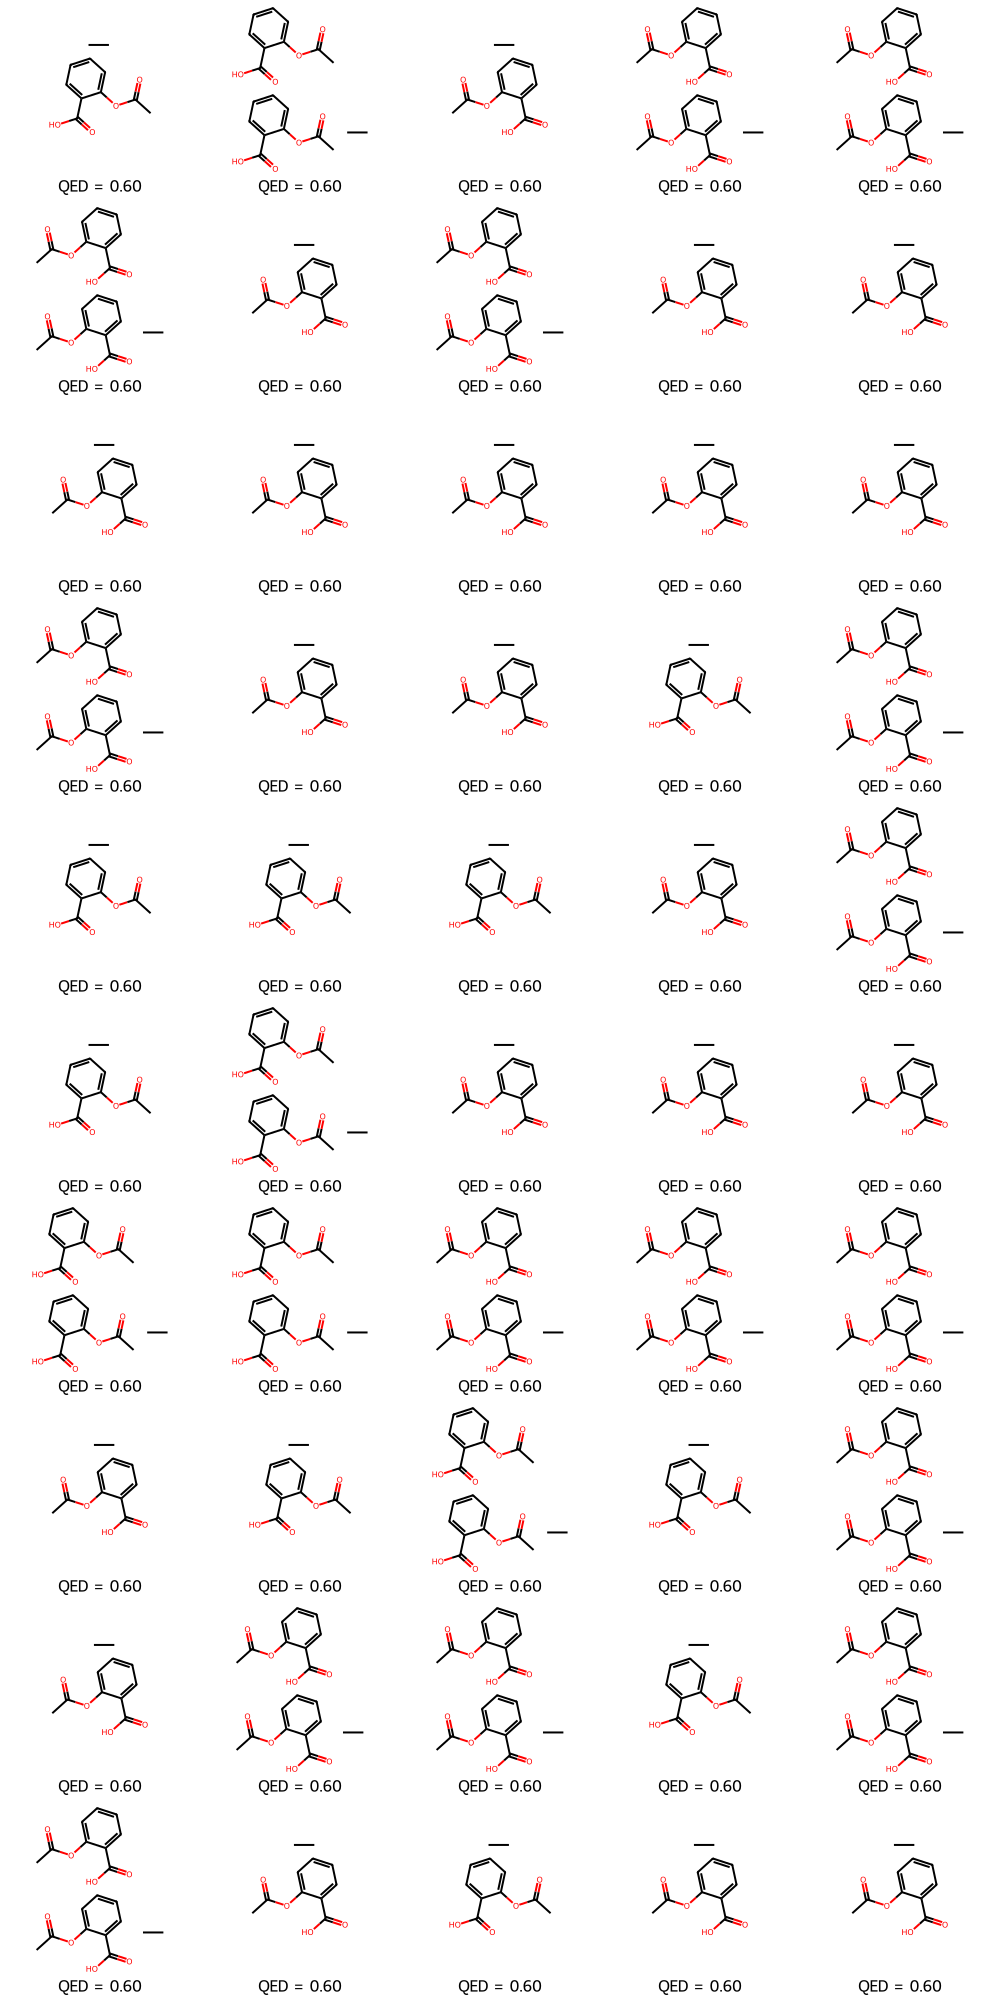

In [ ]:
from rdkit.Chem import Draw
from rdkit.Chem.Draw import DrawingOptions

DrawingOptions.atomLabelFontSize = 50
DrawingOptions.dotsPerAngstrom = 100
DrawingOptions.bondLineWidth = 3

smiles_list = [smiles for smiles, qed_score in env.good_qed_molecules]
generated_mols = [Chem.MolFromSmiles(sm, sanitize=True) for sm in smiles_list]
sanitized_gen_mols = [mol for mol in generated_mols if mol is not None]

n_to_draw = min(200, len(sanitized_gen_mols))  # Draw up to 20 molecules
ind = np.random.randint(0, len(sanitized_gen_mols), n_to_draw)
mols_to_draw = [sanitized_gen_mols[i] for i in ind]
legends = [f'QED = {env.good_qed_molecules[i][1]:.2f}' for i in ind]
Draw.MolsToGridImage(mols_to_draw, molsPerRow=5, subImgSize=(200,200), legends=legends)

Only unique ones

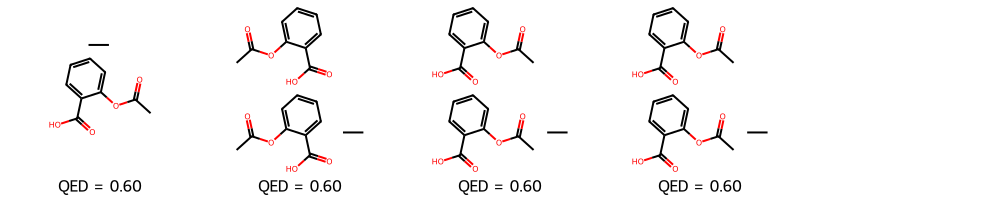

In [ ]:
# Filter out duplicates before drawing
unique_good_qed_molecules = list({smiles: qed_score for smiles, qed_score in env.good_qed_molecules}.items())

# Extract SMILES and QED scores
smiles_list = [smiles for smiles, qed_score in unique_good_qed_molecules]
qed_scores = [qed_score for smiles, qed_score in unique_good_qed_molecules]

# Generate molecule objects from SMILES
generated_mols = [Chem.MolFromSmiles(sm, sanitize=True) for sm in smiles_list]

# Sanitize and filter out None molecules
sanitized_gen_mols = [mol for mol in generated_mols if mol is not None]

# Draw up to 20 molecules
n_to_draw = min(100, len(sanitized_gen_mols))
ind = np.random.randint(0, len(sanitized_gen_mols), n_to_draw)
mols_to_draw = [sanitized_gen_mols[i] for i in ind]
legends = [f'QED = {qed_scores[i]:.2f}' for i in ind]

# Draw the molecules
Draw.MolsToGridImage(mols_to_draw, molsPerRow=5, subImgSize=(200,200), legends=legends)

Log p

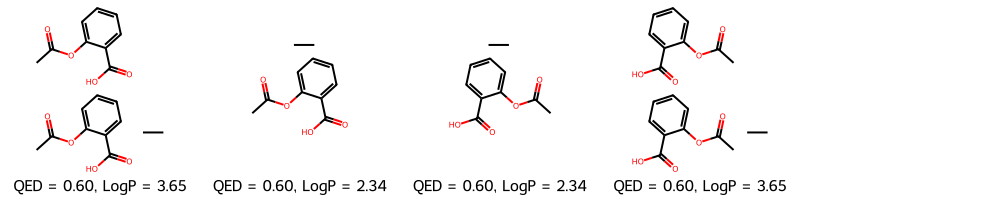

In [ ]:
from rdkit.Chem import Crippen

# Filter out duplicates before drawing
unique_good_qed_molecules = list({smiles: qed_score for smiles, qed_score in env.good_qed_molecules}.items())

# Extract SMILES and QED scores
smiles_list = [smiles for smiles, qed_score in unique_good_qed_molecules]
qed_scores = [qed_score for smiles, qed_score in unique_good_qed_molecules]

# Generate molecule objects from SMILES and calculate LogP values
generated_mols = [Chem.MolFromSmiles(sm, sanitize=True) for sm in smiles_list]
logp_values = [Crippen.MolLogP(mol) for mol in generated_mols]

# Sanitize and filter out None molecules
sanitized_gen_mols = [(mol, qed, logp) for mol, qed, logp in zip(generated_mols, qed_scores, logp_values) if mol is not None]

# Draw up to 20 molecules
n_to_draw = min(20, len(sanitized_gen_mols))
ind = np.random.choice(len(sanitized_gen_mols), n_to_draw, replace=False)
mols_to_draw = [sanitized_gen_mols[i][0] for i in ind]
legends = [f'QED = {sanitized_gen_mols[i][1]:.2f}, LogP = {sanitized_gen_mols[i][2]:.2f}' for i in ind]

# Draw the molecules
Draw.MolsToGridImage(mols_to_draw, molsPerRow=5, subImgSize=(200,200), legends=legends)